# Install

In [26]:
# !pip install -q pillow opencv-python matplotlib seaborn imagehash scikit-image tqdm


# Imports

In [63]:
import re
import os
import gc
import cv2
import json
import hashlib
import warnings
import imagehash
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from PIL import Image
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import pearsonr
from urllib.parse import urlparse
from collections import defaultdict
from dateutil import parser as date_parser
warnings.filterwarnings('ignore')

# Constants

In [28]:
class CONFIG:
    JSON_PATH = "/kaggle/input/openeventsv1-dataset/database.json"
    IMAGE_DIR = "/kaggle/input/openeventsv1-dataset/database_compressed_images/database_images_compressed90"
    
    SAMPLE_SIZE = 10000
    COLOR_SAMPLE_SIZE = 500
    RANDOM_SEED = 42
    
    FIGSIZE = (12, 6)
    DPI = 100

np.random.seed(CONFIG.RANDOM_SEED)
print(f"JSON Path: {CONFIG.JSON_PATH}")
print(f"Image Directory: {CONFIG.IMAGE_DIR}")

JSON Path: /kaggle/input/openeventsv1-dataset/database.json
Image Directory: /kaggle/input/openeventsv1-dataset/database_compressed_images/database_images_compressed90


# Utility Functions

In [29]:
def get_image_properties(img_path):
    try:
        img = Image.open(img_path)
        return {
            'path': str(img_path),
            'width': img.width,
            'height': img.height,
            'mode': img.mode,
            'format': img.format,
            'size_bytes': os.path.getsize(img_path),
            'aspect_ratio': round(img.width / img.height, 2) if img.height > 0 else 0,
            'is_readable': True
        }
    except Exception as e:
        return {
            'path': str(img_path),
            'width': None,
            'height': None,
            'mode': None,
            'format': None,
            'size_bytes': None,
            'aspect_ratio': None,
            'is_readable': False,
            'error': str(e)
        }

def compute_perceptual_hash(img_path, hash_size=8):
    try:
        img = Image.open(img_path)
        return str(imagehash.average_hash(img, hash_size=hash_size))
    except:
        return None

def get_color_stats(img_path):
    try:
        img = cv2.imread(str(img_path))
        if img is None:
            return None
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return {
            'mean_r': np.mean(img_rgb[:, :, 0]),
            'mean_g': np.mean(img_rgb[:, :, 1]),
            'mean_b': np.mean(img_rgb[:, :, 2]),
            'std_r': np.std(img_rgb[:, :, 0]),
            'std_g': np.std(img_rgb[:, :, 1]),
            'std_b': np.std(img_rgb[:, :, 2])
        }
    except:
        return None

def compute_md5_hash(img_path):
    hash_md5 = hashlib.md5()
    try:
        with open(img_path, "rb") as f:
            for chunk in iter(lambda: f.read(4096), b""):
                hash_md5.update(chunk)
        return hash_md5.hexdigest()
    except:
        return None

def compute_blur_score(img_path):
    try:
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None
        laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
        return laplacian_var
    except:
        return None

def compute_brightness(img_path):
    try:
        img = cv2.imread(str(img_path))
        if img is None:
            return None
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return img_gray.mean()
    except:
        return None

def extract_exif(img_path):
    try:
        from PIL.ExifTags import TAGS
        img = Image.open(img_path)
        exif_data = img.getexif()
        if exif_data is None:
            return {}
        exif_dict = {}
        for tag_id, value in exif_data.items():
            tag_name = TAGS.get(tag_id, tag_id)
            exif_dict[tag_name] = value
        return exif_dict
    except:
        return {}


def load_json_safe(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def extract_domain(url):
    try:
        return urlparse(url).netloc
    except:
        return None

def parse_date_safe(date_str):
    try:
        return date_parser.parse(date_str)
    except:
        return None

def simple_tokenize(text):
    if not text:
        return []
    text = text.lower()
    words = re.findall(r'\b[a-z]+\b', text)
    return words

def extract_capitalized_words(text):
    if not text:
        return []
    return re.findall(r'\b[A-Z][a-z]+\b', text)

def compute_sentence_count(text):
    if not text:
        return 0
    sentences = re.split(r'[.!?]+', text)
    return len([s for s in sentences if s.strip()])

def extract_ngrams(words, n):
    return [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]

# Image EDA

## 1. Image Inventory and Integrity

In [30]:
print("IMAGE INVENTORY & INTEGRITY CHECK")

image_dir = Path(CONFIG.IMAGE_DIR)

all_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

if CONFIG.SAMPLE_SIZE != None and len(all_files) > CONFIG.SAMPLE_SIZE:
    import random
    random.shuffle(all_files)
    sampled_files = all_files[:CONFIG.SAMPLE_SIZE]
else:
    sampled_files = all_files

sampled_images = [image_dir / f for f in sampled_files]
print(f"\nCollected random sample: {len(sampled_images)} images")

print("\nExtracting image properties...")
image_data = []
for img_path in tqdm(sampled_images, desc="Processing"):
    props = get_image_properties_fast(img_path)
    image_data.append(props)

df_images = pd.DataFrame(image_data)

unreadable = df_images[df_images['is_readable'] == False]
print(f"\nIntegrity Report:")
print(f"  Readable: {len(df_images[df_images['is_readable']])} ({len(df_images[df_images['is_readable']])/len(df_images)*100:.2f}%)")
print(f"  Unreadable: {len(unreadable)} ({len(unreadable)/len(df_images)*100:.2f}%)")

if len(unreadable) > 0:
    print(f"\nFirst 5 unreadable images:")
    for idx, row in unreadable.head(5).iterrows():
        print(f"  {Path(row['path']).name}: {row.get('error', 'Unknown')}")

extensions = Counter([Path(p).suffix.lower() for p in df_images['path']])
print(f"\nFile Extensions:")
for ext, count in extensions.most_common():
    print(f"  {ext}: {count} ({count/len(df_images)*100:.1f}%)")

if 'mode' in df_images.columns:
    print(f"\nImage Modes:")
    mode_counts = df_images['mode'].value_counts()
    for mode, count in mode_counts.items():
        if mode:
            print(f"  {mode}: {count} ({count/len(df_images)*100:.1f}%)")

gc.collect()

IMAGE INVENTORY & INTEGRITY CHECK

Collected random sample: 10000 images

Extracting image properties...


Processing: 100%|██████████| 10000/10000 [01:01<00:00, 161.70it/s]



Integrity Report:
  Readable: 10000 (100.00%)
  Unreadable: 0 (0.00%)

File Extensions:
  .jpg: 10000 (100.0%)

Image Modes:
  RGB: 10000 (100.0%)


5

## 2. Resolution and Aspect Ratios

RESOLUTION & ASPECT RATIO ANALYSIS

Resolution Statistics:
  • Width:  min=120, max=5750, mean=977.2, median=465.0
  • Height: min=64, max=5016, mean=646.8, median=279.0

Orientation Distribution:
  • Landscape: 9374 (93.7%)
  • Portrait: 463 (4.6%)
  • Square: 163 (1.6%)


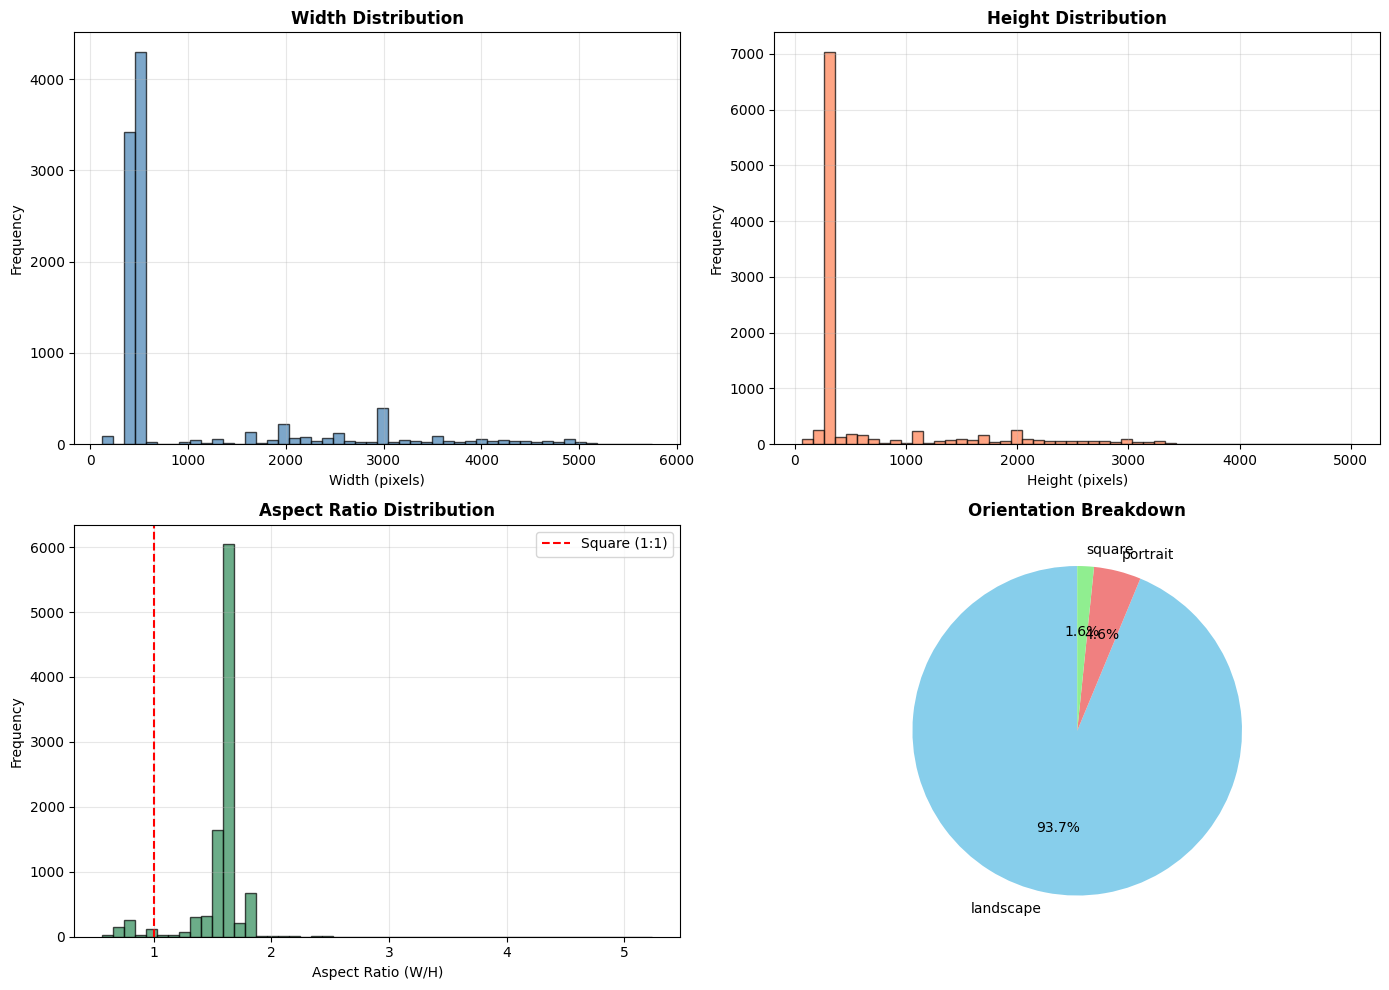


Saved visualization: image_resolution_analysis.png


18470

In [31]:
print("RESOLUTION & ASPECT RATIO ANALYSIS")

df_valid = df_images[df_images['is_readable'] == True].copy()

print(f"\nResolution Statistics:")
print(f"  • Width:  min={df_valid['width'].min()}, max={df_valid['width'].max()}, "
      f"mean={df_valid['width'].mean():.1f}, median={df_valid['width'].median():.1f}")
print(f"  • Height: min={df_valid['height'].min()}, max={df_valid['height'].max()}, "
      f"mean={df_valid['height'].mean():.1f}, median={df_valid['height'].median():.1f}")

df_valid['orientation'] = df_valid['aspect_ratio'].apply(
    lambda x: 'landscape' if x > 1.1 else ('portrait' if x < 0.9 else 'square')
)
print(f"\nOrientation Distribution:")
orient_counts = df_valid['orientation'].value_counts()
for orient, count in orient_counts.items():
    print(f"  • {orient.capitalize()}: {count} ({count/len(df_valid)*100:.1f}%)")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(df_valid['width'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Width Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Width (pixels)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist(df_valid['height'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Height Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Height (pixels)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(alpha=0.3)

axes[1, 0].hist(df_valid['aspect_ratio'], bins=50, color='seagreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Aspect Ratio Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Aspect Ratio (W/H)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(1.0, color='red', linestyle='--', label='Square (1:1)')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

axes[1, 1].pie(orient_counts.values, labels=orient_counts.index, autopct='%1.1f%%', 
               startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen'])
axes[1, 1].set_title('Orientation Breakdown', fontweight='bold')

plt.tight_layout()
plt.savefig('image_resolution_analysis.png', dpi=CONFIG.DPI, bbox_inches='tight')
plt.show()

print(f"\nSaved visualization: image_resolution_analysis.png")

del fig, axes
gc.collect()


## 3. File Size Distribution

FILE SIZE ANALYSIS

File Size Statistics (MB):
  • Min:    0.001
  • Max:    0.967
  • Mean:   0.040
  • Median: 0.007
  • Total:  395.41 MB


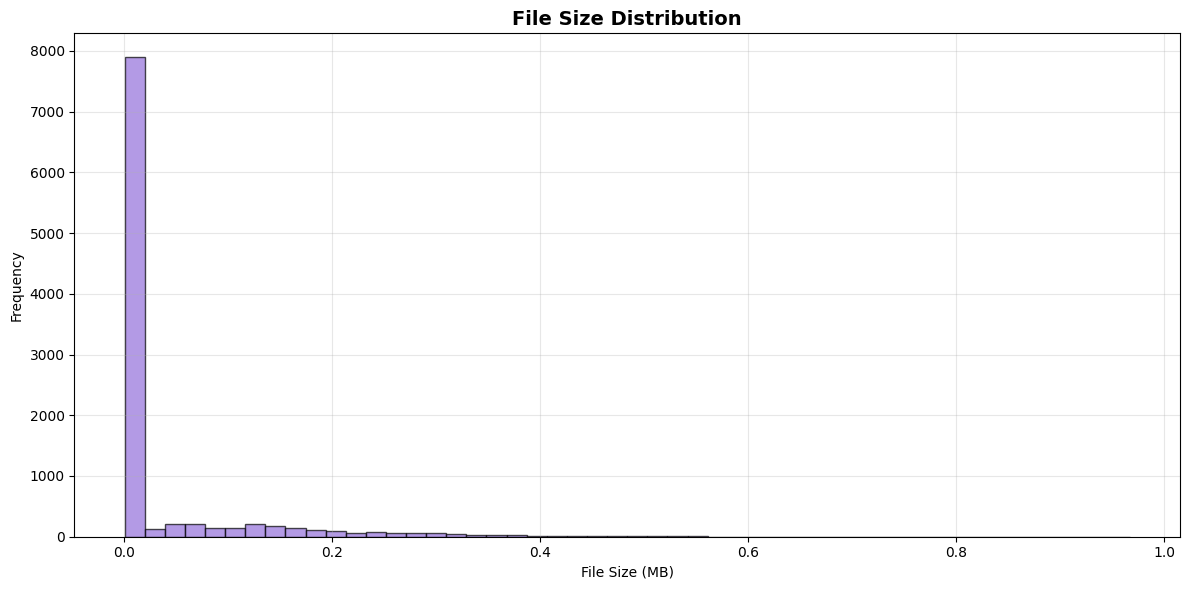


Saved visualization: image_filesize_distribution.png


5743

In [32]:
print("FILE SIZE ANALYSIS")

df_valid['size_mb'] = df_valid['size_bytes'] / (1024 * 1024)

print(f"\nFile Size Statistics (MB):")
print(f"  • Min:    {df_valid['size_mb'].min():.3f}")
print(f"  • Max:    {df_valid['size_mb'].max():.3f}")
print(f"  • Mean:   {df_valid['size_mb'].mean():.3f}")
print(f"  • Median: {df_valid['size_mb'].median():.3f}")
print(f"  • Total:  {df_valid['size_mb'].sum():.2f} MB")

plt.figure(figsize=CONFIG.FIGSIZE)
plt.hist(df_valid['size_mb'], bins=50, color='mediumpurple', edgecolor='black', alpha=0.7)
plt.title('File Size Distribution', fontweight='bold', fontsize=14)
plt.xlabel('File Size (MB)')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('image_filesize_distribution.png', dpi=CONFIG.DPI, bbox_inches='tight')
plt.show()

print(f"\nSaved visualization: image_filesize_distribution.png")

gc.collect()

## 4. Color Statistics

COLOR STATISTICS ANALYSIS

Computing color statistics for 500 images...


Analyzing colors: 100%|██████████| 500/500 [00:22<00:00, 22.65it/s]



Color Channel Statistics:

  RED Channel:
    • Mean: 109.03 ± 62.81

  GREEN Channel:
    • Mean: 102.02 ± 59.43

  BLUE Channel:
    • Mean: 98.91 ± 60.29


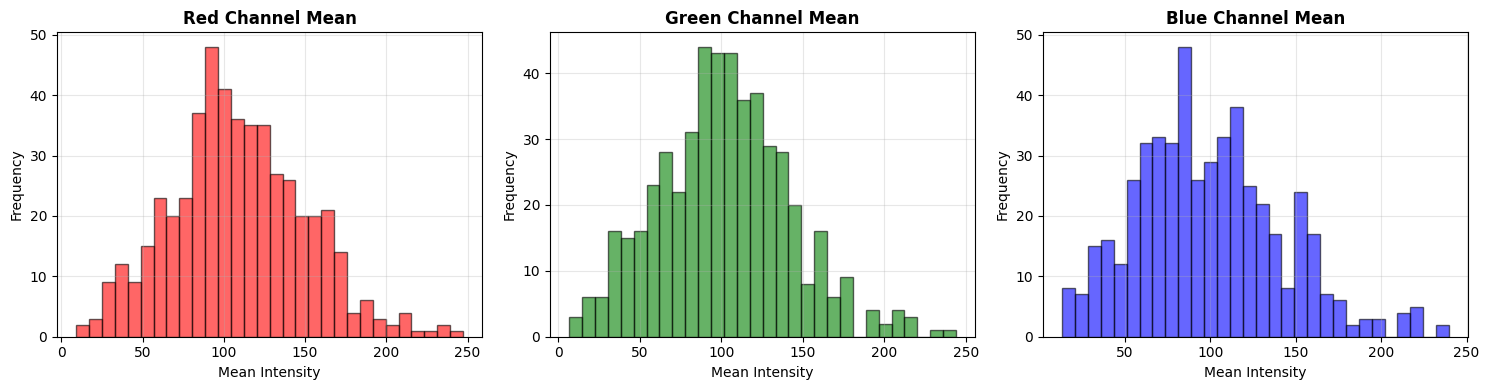


Saved visualization: image_color_analysis.png


12694

In [33]:
print("COLOR STATISTICS ANALYSIS")

color_sample_size = min(500, len(df_valid))
color_sample_paths = df_valid['path'].sample(color_sample_size, random_state=CONFIG.RANDOM_SEED).tolist()

print(f"\nComputing color statistics for {color_sample_size} images...")
color_stats = []
for img_path in tqdm(color_sample_paths, desc="Analyzing colors"):
    stats = get_color_stats(img_path)
    if stats:
        color_stats.append(stats)

df_colors = pd.DataFrame(color_stats)

print(f"\nColor Channel Statistics:")
print(f"\n  RED Channel:")
print(f"    • Mean: {df_colors['mean_r'].mean():.2f} ± {df_colors['std_r'].mean():.2f}")
print(f"\n  GREEN Channel:")
print(f"    • Mean: {df_colors['mean_g'].mean():.2f} ± {df_colors['std_g'].mean():.2f}")
print(f"\n  BLUE Channel:")
print(f"    • Mean: {df_colors['mean_b'].mean():.2f} ± {df_colors['std_b'].mean():.2f}")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df_colors['mean_r'], bins=30, color='red', alpha=0.6, edgecolor='black')
axes[0].set_title('Red Channel Mean', fontweight='bold')
axes[0].set_xlabel('Mean Intensity')
axes[0].set_ylabel('Frequency')
axes[0].grid(alpha=0.3)

axes[1].hist(df_colors['mean_g'], bins=30, color='green', alpha=0.6, edgecolor='black')
axes[1].set_title('Green Channel Mean', fontweight='bold')
axes[1].set_xlabel('Mean Intensity')
axes[1].set_ylabel('Frequency')
axes[1].grid(alpha=0.3)

axes[2].hist(df_colors['mean_b'], bins=30, color='blue', alpha=0.6, edgecolor='black')
axes[2].set_title('Blue Channel Mean', fontweight='bold')
axes[2].set_xlabel('Mean Intensity')
axes[2].set_ylabel('Frequency')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('image_color_analysis.png', dpi=CONFIG.DPI, bbox_inches='tight')
plt.show()

print(f"\nSaved visualization: image_color_analysis.png")

del fig, axes, df_colors
gc.collect()


## 5. True Duplicate Detection

In [34]:
print("TRUE DUPLICATE DETECTION (MD5)")

print("\nComputing MD5 hashes for exact duplicate detection...")
md5_hashes = []
for img_path in tqdm(df_valid['path'].tolist()[:CONFIG.SAMPLE_SIZE], desc="Computing MD5"):
    h = compute_md5_hash(img_path)
    md5_hashes.append(h)

df_md5 = df_valid.head(len(md5_hashes)).copy()
df_md5['md5'] = md5_hashes

md5_counts = df_md5['md5'].value_counts()
exact_duplicates = md5_counts[md5_counts > 1]

print(f"\nExact Duplicate Results:")
print(f"  Unique images: {len(md5_counts[md5_counts == 1])}")
print(f"  Duplicate groups: {len(exact_duplicates)}")
print(f"  Total duplicate images: {exact_duplicates.sum() - len(exact_duplicates) if len(exact_duplicates) > 0 else 0}")

if len(exact_duplicates) > 0:
    print(f"\nTop 5 Exact Duplicate Groups:")
    for idx, (md5_val, count) in enumerate(exact_duplicates.head(5).items(), 1):
        print(f"  {idx}. MD5 {md5_val[:16]}... -> {count} exact copies")
        sample_paths = df_md5[df_md5['md5'] == md5_val]['path'].head(3)
        for p in sample_paths:
            print(f"      - {Path(p).name}")
else:
    print("\nNo exact duplicates found in sample")


gc.collect()


TRUE DUPLICATE DETECTION (MD5)

Computing MD5 hashes for exact duplicate detection...


Computing MD5: 100%|██████████| 10000/10000 [00:06<00:00, 1544.44it/s]



Exact Duplicate Results:
  Unique images: 10000
  Duplicate groups: 0
  Total duplicate images: 0

No exact duplicates found in sample


0

## 6. Image Quality Metrics

IMAGE QUALITY METRICS

Analyzing quality metrics for 500 images...


Quality analysis: 100%|██████████| 500/500 [00:12<00:00, 40.07it/s]



Blur Analysis (Laplacian Variance):
  Mean blur score: 672.73
  Median blur score: 444.67
  Min blur score: 14.72
  Max blur score: 9826.36
  Blurry images (score < 100): 45 (9.0%)

Brightness Analysis:
  Mean brightness: 103.77
  Median brightness: 101.84
  Min brightness: 10.30
  Max brightness: 244.38
  Dark images (brightness < 50): 42 (8.4%)
  Overexposed images (brightness > 200): 10 (2.0%)


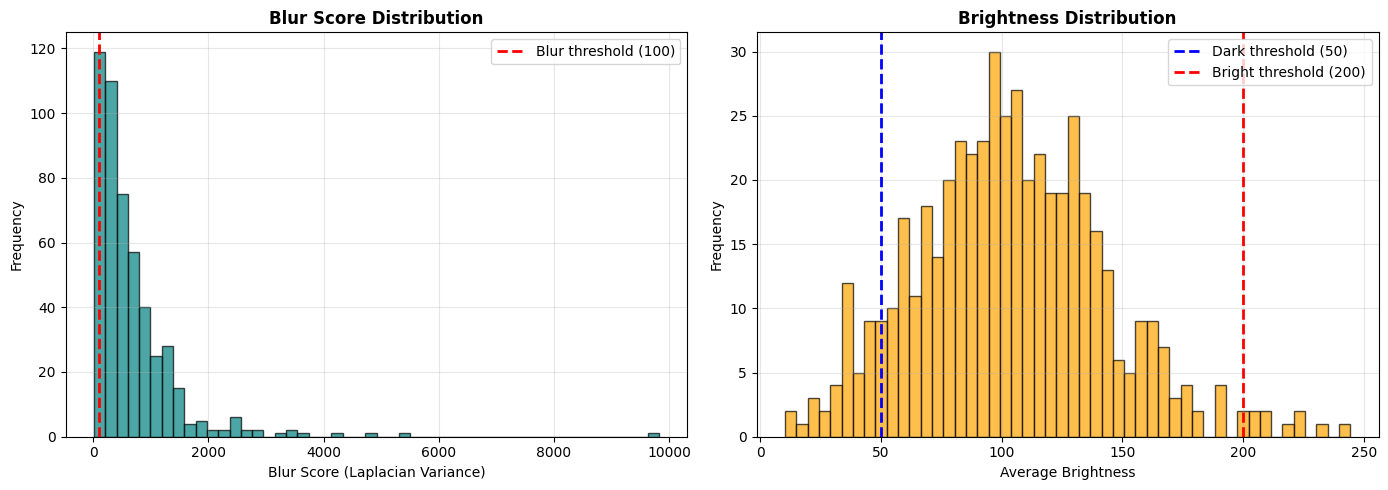


Saved visualization: image_quality_analysis.png


11547

In [35]:
print("IMAGE QUALITY METRICS")

quality_sample_size = min(500, len(df_valid))
quality_sample_paths = df_valid['path'].sample(quality_sample_size, random_state=CONFIG.RANDOM_SEED).tolist()

print(f"\nAnalyzing quality metrics for {quality_sample_size} images...")

blur_scores = []
brightness_values = []

for img_path in tqdm(quality_sample_paths, desc="Quality analysis"):
    blur = compute_blur_score(img_path)
    bright = compute_brightness(img_path)
    blur_scores.append(blur)
    brightness_values.append(bright)

df_quality = pd.DataFrame({
    'path': quality_sample_paths,
    'blur_score': blur_scores,
    'brightness': brightness_values
})

df_quality = df_quality.dropna()

blur_threshold = 100
blurry_count = (df_quality['blur_score'] < blur_threshold).sum()

print(f"\nBlur Analysis (Laplacian Variance):")
print(f"  Mean blur score: {df_quality['blur_score'].mean():.2f}")
print(f"  Median blur score: {df_quality['blur_score'].median():.2f}")
print(f"  Min blur score: {df_quality['blur_score'].min():.2f}")
print(f"  Max blur score: {df_quality['blur_score'].max():.2f}")
print(f"  Blurry images (score < {blur_threshold}): {blurry_count} ({blurry_count/len(df_quality)*100:.1f}%)")

print(f"\nBrightness Analysis:")
print(f"  Mean brightness: {df_quality['brightness'].mean():.2f}")
print(f"  Median brightness: {df_quality['brightness'].median():.2f}")
print(f"  Min brightness: {df_quality['brightness'].min():.2f}")
print(f"  Max brightness: {df_quality['brightness'].max():.2f}")

dark_threshold = 50
bright_threshold = 200
dark_count = (df_quality['brightness'] < dark_threshold).sum()
bright_count = (df_quality['brightness'] > bright_threshold).sum()

print(f"  Dark images (brightness < {dark_threshold}): {dark_count} ({dark_count/len(df_quality)*100:.1f}%)")
print(f"  Overexposed images (brightness > {bright_threshold}): {bright_count} ({bright_count/len(df_quality)*100:.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_quality['blur_score'], bins=50, color='teal', edgecolor='black', alpha=0.7)
axes[0].axvline(blur_threshold, color='red', linestyle='--', linewidth=2, label=f'Blur threshold ({blur_threshold})')
axes[0].set_xlabel('Blur Score (Laplacian Variance)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Blur Score Distribution', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(df_quality['brightness'], bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[1].axvline(dark_threshold, color='blue', linestyle='--', linewidth=2, label=f'Dark threshold ({dark_threshold})')
axes[1].axvline(bright_threshold, color='red', linestyle='--', linewidth=2, label=f'Bright threshold ({bright_threshold})')
axes[1].set_xlabel('Average Brightness')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Brightness Distribution', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('image_quality_analysis.png', dpi=CONFIG.DPI, bbox_inches='tight')
plt.show()

print(f"\nSaved visualization: image_quality_analysis.png")

del fig, axes
gc.collect()


## 7. Image Metadata Analysis

In [36]:
print("IMAGE METADATA ANALYSIS (EXIF)")

exif_sample_size = min(200, len(df_valid))
exif_sample_paths = df_valid['path'].sample(exif_sample_size, random_state=CONFIG.RANDOM_SEED).tolist()

print(f"\nExtracting EXIF metadata from {exif_sample_size} images...")

exif_records = []
for img_path in tqdm(exif_sample_paths, desc="Extracting EXIF"):
    exif = extract_exif(img_path)
    exif_records.append({
        'path': str(img_path),
        'has_exif': len(exif) > 0,
        'make': exif.get('Make', None),
        'model': exif.get('Model', None),
        'datetime': exif.get('DateTime', None),
        'gps': exif.get('GPSInfo', None) is not None
    })

df_exif = pd.DataFrame(exif_records)

images_with_exif = df_exif['has_exif'].sum()
images_with_gps = df_exif['gps'].sum()

print(f"\nEXIF Metadata Summary:")
print(f"  Images with EXIF data: {images_with_exif} ({images_with_exif/len(df_exif)*100:.1f}%)")
print(f"  Images with GPS data: {images_with_gps} ({images_with_gps/len(df_exif)*100:.1f}%)")

if df_exif['make'].notna().sum() > 0:
    print(f"\nTop Camera Manufacturers:")
    make_counts = df_exif['make'].value_counts().head(5)
    for make, count in make_counts.items():
        print(f"  {make}: {count}")

if df_exif['model'].notna().sum() > 0:
    print(f"\nTop Camera Models:")
    model_counts = df_exif['model'].value_counts().head(5)
    for model, count in model_counts.items():
        print(f"  {model}: {count}")


gc.collect()


IMAGE METADATA ANALYSIS (EXIF)

Extracting EXIF metadata from 200 images...


Extracting EXIF: 100%|██████████| 200/200 [00:00<00:00, 1096.58it/s]


EXIF Metadata Summary:
  Images with EXIF data: 0 (0.0%)
  Images with GPS data: 0 (0.0%)


0

## 8. Edge Cases and Outliers

In [37]:
print("EDGE CASES AND OUTLIERS")

print(f"\nAnalyzing edge cases in dataset...")

very_small = df_valid[(df_valid['width'] < 100) | (df_valid['height'] < 100)]
very_large = df_valid[(df_valid['width'] > 5000) | (df_valid['height'] > 5000)]
extreme_aspect = df_valid[(df_valid['aspect_ratio'] > 10) | (df_valid['aspect_ratio'] < 0.1)]

print(f"\nSize Outliers:")
print(f"  Very small images (<100px): {len(very_small)} ({len(very_small)/len(df_valid)*100:.2f}%)")
if len(very_small) > 0:
    print(f"    Smallest: {very_small['width'].min()}x{very_small['height'].min()}")
    
print(f"  Very large images (>5000px): {len(very_large)} ({len(very_large)/len(df_valid)*100:.2f}%)")
if len(very_large) > 0:
    print(f"    Largest: {very_large['width'].max()}x{very_large['height'].max()}")

print(f"\nAspect Ratio Outliers:")
print(f"  Extreme aspect ratios (>10:1 or <1:10): {len(extreme_aspect)} ({len(extreme_aspect)/len(df_valid)*100:.2f}%)")
if len(extreme_aspect) > 0:
    print(f"    Most extreme: {extreme_aspect['aspect_ratio'].max():.2f}")

grayscale_count = (df_valid['mode'] == 'L').sum() if 'L' in df_valid['mode'].values else 0
rgba_count = (df_valid['mode'] == 'RGBA').sum() if 'RGBA' in df_valid['mode'].values else 0
rgb_count = (df_valid['mode'] == 'RGB').sum() if 'RGB' in df_valid['mode'].values else 0

print(f"\nColor Mode Distribution:")
print(f"  RGB (color): {rgb_count} ({rgb_count/len(df_valid)*100:.1f}%)")
print(f"  Grayscale: {grayscale_count} ({grayscale_count/len(df_valid)*100:.1f}%)")
print(f"  RGBA (transparency): {rgba_count} ({rgba_count/len(df_valid)*100:.1f}%)")


gc.collect()

EDGE CASES AND OUTLIERS

Analyzing edge cases in dataset...

Size Outliers:
  Very small images (<100px): 13 (0.13%)
    Smallest: 120x64
  Very large images (>5000px): 43 (0.43%)
    Largest: 5750x5016

Aspect Ratio Outliers:
  Extreme aspect ratios (>10:1 or <1:10): 0 (0.00%)

Color Mode Distribution:
  RGB (color): 10000 (100.0%)
  Grayscale: 0 (0.0%)
  RGBA (transparency): 0 (0.0%)


0

## 9. Summary Report

In [38]:
print("COMPLETE IMAGE EDA SUMMARY REPORT")

print(f"\nDataset Overview:")
print(f"  Total images found: {len(all_image_paths)}")
print(f"  Analyzed sample: {len(sampled_images)}")
print(f"  Readable: {len(df_valid)} ({len(df_valid)/len(sampled_images)*100:.1f}%)")
print(f"  Corrupt: {len(unreadable)} ({len(unreadable)/len(sampled_images)*100:.1f}%)")

print(f"\nDimensions:")
print(f"  Avg resolution: {df_valid['width'].mean():.0f} x {df_valid['height'].mean():.0f}")
print(f"  Orientation: {orient_counts.idxmax()} dominant ({orient_counts.max()} images)")

print(f"\nDuplicate Detection:")
if len(exact_duplicates) > 0:
    print(f"  Exact duplicates: {len(exact_duplicates)} groups, {exact_duplicates.sum() - len(exact_duplicates)} duplicate images")
else:
    print(f"  No exact duplicates found")

print(f"\nQuality Metrics:")
print(f"  Avg blur score: {df_quality['blur_score'].mean():.2f}")
print(f"  Blurry images: {blurry_count} ({blurry_count/len(df_quality)*100:.1f}%)")
print(f"  Avg brightness: {df_quality['brightness'].mean():.2f}")
print(f"  Dark images: {dark_count} ({dark_count/len(df_quality)*100:.1f}%)")
print(f"  Overexposed images: {bright_count} ({bright_count/len(df_quality)*100:.1f}%)")

print(f"\nMetadata:")
print(f"  Images with EXIF: {images_with_exif}/{len(df_exif)} ({images_with_exif/len(df_exif)*100:.1f}%)")
print(f"  Images with GPS: {images_with_gps}/{len(df_exif)} ({images_with_gps/len(df_exif)*100:.1f}%)")

print(f"\nOutliers:")
print(f"  Very small (<100px): {len(very_small)}")
print(f"  Very large (>5000px): {len(very_large)}")
print(f"  Extreme aspect ratios: {len(extreme_aspect)}")

print(f"\nStorage:")
print(f"  Total size: {df_valid['size_mb'].sum():.2f} MB")
print(f"  Avg file size: {df_valid['size_mb'].mean():.3f} MB")

COMPLETE IMAGE EDA SUMMARY REPORT

Dataset Overview:
  Total images found: 0
  Analyzed sample: 10000
  Readable: 10000 (100.0%)
  Corrupt: 0 (0.0%)

Dimensions:
  Avg resolution: 977 x 647
  Orientation: landscape dominant (9374 images)

Duplicate Detection:
  No exact duplicates found

Quality Metrics:
  Avg blur score: 672.73
  Blurry images: 45 (9.0%)
  Avg brightness: 103.77
  Dark images: 42 (8.4%)
  Overexposed images: 10 (2.0%)

Metadata:
  Images with EXIF: 0/200 (0.0%)
  Images with GPS: 0/200 (0.0%)

Outliers:
  Very small (<100px): 13
  Very large (>5000px): 43
  Extreme aspect ratios: 0

Storage:
  Total size: 395.41 MB
  Avg file size: 0.040 MB


# JSON EDA

## 1. JSON Schema and Structure

In [49]:
print("JSON SCHEMA AND STRUCTURE ANALYSIS")

print("\nLoading JSON data...")
data = load_json_safe(CONFIG.JSON_PATH)

print(f"\nTop-level keys in JSON: {list(data.keys())[:100]}")

if 'root' in data:
    root_data = data['root']
else:
    root_data = data

print(f"\nTotal articles in JSON: {len(root_data)}")

if len(root_data) == 0:
    print("\nERROR: No articles found in JSON!")
    print("Checking JSON structure...")
    print(f"JSON type: {type(data)}")
    print(f"Keys available: {list(data.keys())[:10]}")
else:
    sample_keys = list(root_data.keys())[:3]
    print(f"\nSample article IDs: {sample_keys}")
    
    first_article = root_data[sample_keys[0]]
    print(f"\nTop-level keys per article:")
    for key in first_article.keys():
        print(f"  {key}")
    
    print(f"\nField Types:")
    for key, value in first_article.items():
        if isinstance(value, list):
            print(f"  {key}: list (length: {len(value)})")
        else:
            print(f"  {key}: {type(value).__name__}")


gc.collect()


JSON SCHEMA AND STRUCTURE ANALYSIS

Loading JSON data...

Top-level keys in JSON: ['f8097c7d27a8aac6', 'c9c8b01d91802400', 'a541373b24d18b17', 'b827f80c1306c787', '30f174bb655d403a', '9f402e296be38f87', '244eb1053673c3e5', '1662fac84d796f54', '208ff446cde2f784', 'e3ff6311653bc009', '5b423cd3001df187', '881c6125d9c12f73', 'f0e070084ab0dadc', '63717594d99cf1a0', 'e936dc8e896e3793', '378ac6333520e773', 'd11a82cca5130f41', '8ca1d8a8331af857', 'e41b4356865304dd', '3598eae03ac65ea4', '5ec77ef2ea134ae9', '148ad97b157992a2', '16cfd0df99e13007', '171bfbb330fc22b6', 'd21ab7524f86ce98', 'ce22deab2d88dc89', 'f40ccb60b445b19d', '88b972587fcfb50f', 'adab8fb82f2cefa1', 'c4c93a7db03bc8dd', '71b2c745b17da382', '6485b2383a1f95b3', '3fc19e20c2765693', '410fbd47437caf51', 'fa5336a6d7960b0c', 'e98f23ca45f7f5a3', '72c76ac92e88a5ea', '3b6225f34521a60b', '0bb3dadaac4acff3', '2e014112b13f6805', '645db275830ce53f', '0a8e922202adf9ef', '41e0accd504a6e36', 'ad9e9a3235469a02', 'e30094110a0a07f5', 'a36eb5e2d8e20708

0

## 2. Missingness and Validity

MISSINGNESS AND VALIDITY ANALYSIS

Missing Values:
  id: 0 (0.00%)
  url: 0 (0.00%)
  date: 0 (0.00%)
  title: 0 (0.00%)
  content: 0 (0.00%)
  num_images: 0 (0.00%)

Empty Strings:
  url: 0 (0.00%)
  title: 0 (0.00%)
  content: 0 (0.00%)

Basic Statistics:
  Total articles: 202803
  Unique IDs: 202803
  ID collision: 0


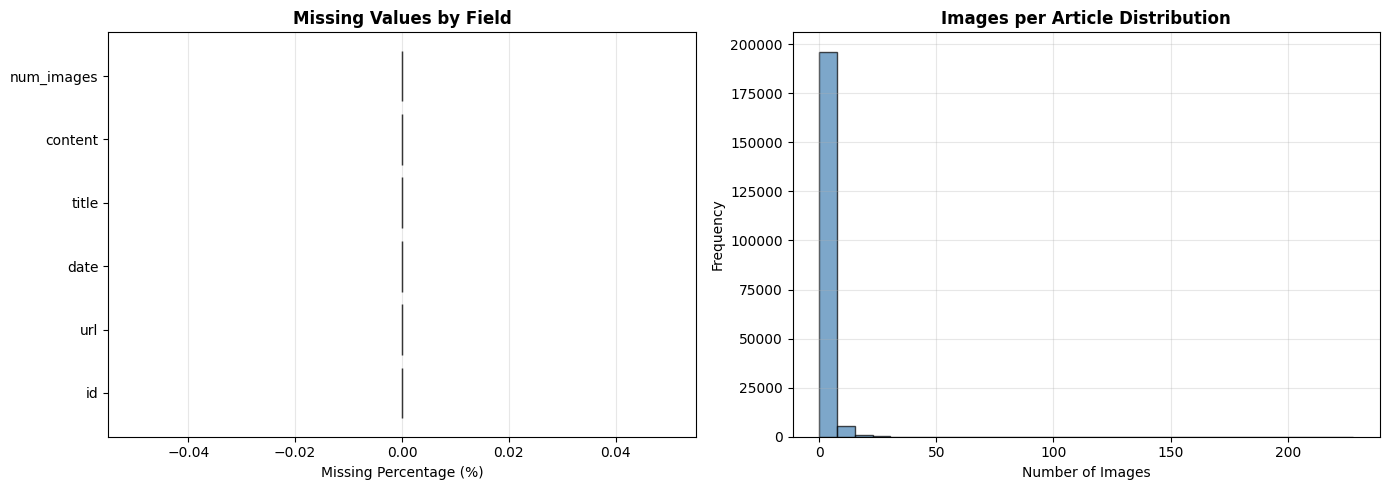


Saved visualization: json_missingness_analysis.png


In [40]:
print("MISSINGNESS AND VALIDITY ANALYSIS")

if len(root_data) == 0:
    print("\nSkipping analysis - no data found")
else:
    articles_list = []
    for article_id, article_data in root_data.items():
        article_info = {
            'id': article_id,
            'url': article_data.get('url'),
            'date': article_data.get('date'),
            'title': article_data.get('title'),
            'content': article_data.get('content'),
            'num_images': len(article_data.get('images', []))
        }
        articles_list.append(article_info)
    
    df_articles = pd.DataFrame(articles_list)
    
    print(f"\nMissing Values:")
    missing_counts = df_articles.isnull().sum()
    for col, count in missing_counts.items():
        pct = (count / len(df_articles)) * 100
        print(f"  {col}: {count} ({pct:.2f}%)")
    
    print(f"\nEmpty Strings:")
    for col in ['url', 'title', 'content']:
        if col in df_articles.columns:
            empty_count = (df_articles[col] == '').sum()
            pct = (empty_count / len(df_articles)) * 100
            print(f"  {col}: {empty_count} ({pct:.2f}%)")
    
    print(f"\nBasic Statistics:")
    print(f"  Total articles: {len(df_articles)}")
    print(f"  Unique IDs: {df_articles['id'].nunique()}")
    print(f"  ID collision: {len(df_articles) - df_articles['id'].nunique()}")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    missing_pct = (df_articles.isnull().sum() / len(df_articles) * 100).sort_values(ascending=False)
    axes[0].barh(missing_pct.index, missing_pct.values, color='coral', edgecolor='black')
    axes[0].set_xlabel('Missing Percentage (%)')
    axes[0].set_title('Missing Values by Field', fontweight='bold')
    axes[0].grid(alpha=0.3, axis='x')
    
    axes[1].hist(df_articles['num_images'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Number of Images')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Images per Article Distribution', fontweight='bold')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('json_missingness_analysis.png', dpi=CONFIG.DPI, bbox_inches='tight')
    plt.show()
    
    print(f"\nSaved visualization: json_missingness_analysis.png")
    
    del fig, axes
    gc.collect()


## 3. Text Field Analysis

TEXT FIELD ANALYSIS

Title Length Statistics:
  Min: 4
  Max: 211
  Mean: 71.8
  Median: 71.0

Content Length Statistics:
  Min: 5
  Max: 74431
  Mean: 4910.9
  Median: 4349.0

URL Length Statistics:
  Min: 40
  Max: 325
  Mean: 108.8
  Median: 109.0


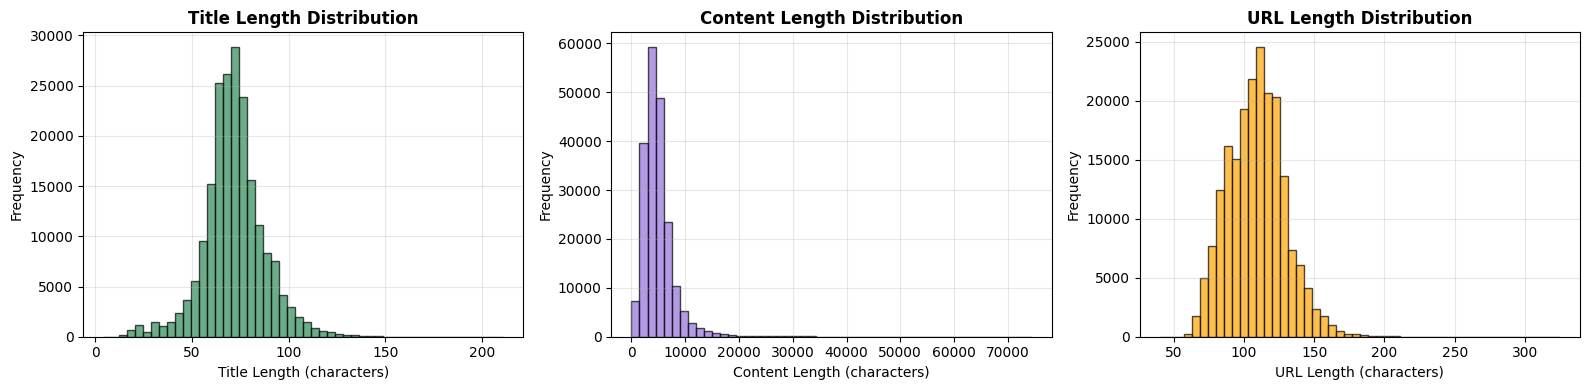


Saved visualization: json_text_length_analysis.png


16379

In [41]:
print("TEXT FIELD ANALYSIS")

df_articles['title_length'] = df_articles['title'].str.len()
df_articles['content_length'] = df_articles['content'].str.len()
df_articles['url_length'] = df_articles['url'].str.len()

print(f"\nTitle Length Statistics:")
print(f"  Min: {df_articles['title_length'].min()}")
print(f"  Max: {df_articles['title_length'].max()}")
print(f"  Mean: {df_articles['title_length'].mean():.1f}")
print(f"  Median: {df_articles['title_length'].median():.1f}")

print(f"\nContent Length Statistics:")
print(f"  Min: {df_articles['content_length'].min()}")
print(f"  Max: {df_articles['content_length'].max()}")
print(f"  Mean: {df_articles['content_length'].mean():.1f}")
print(f"  Median: {df_articles['content_length'].median():.1f}")

print(f"\nURL Length Statistics:")
print(f"  Min: {df_articles['url_length'].min()}")
print(f"  Max: {df_articles['url_length'].max()}")
print(f"  Mean: {df_articles['url_length'].mean():.1f}")
print(f"  Median: {df_articles['url_length'].median():.1f}")

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].hist(df_articles['title_length'], bins=50, color='seagreen', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Title Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Title Length Distribution', fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].hist(df_articles['content_length'], bins=50, color='mediumpurple', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Content Length (characters)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Content Length Distribution', fontweight='bold')
axes[1].grid(alpha=0.3)

axes[2].hist(df_articles['url_length'], bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[2].set_xlabel('URL Length (characters)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('URL Length Distribution', fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('json_text_length_analysis.png', dpi=CONFIG.DPI, bbox_inches='tight')
plt.show()

print(f"\nSaved visualization: json_text_length_analysis.png")

del fig, axes
gc.collect()


## 4. Temporal Coverage

TEMPORAL COVERAGE ANALYSIS

Date Parsing:
  Valid dates: 202803 (100.0%)
  Invalid dates: 0 (0.0%)

Date Range:
  Earliest: 2011-08-24 17:54:07+00:00
  Latest: 2025-02-14 23:14:34+00:00

Articles by Year:
  2011: 757
  2012: 2269
  2013: 1857
  2014: 1123
  2015: 1775
  2016: 2248
  2017: 1997
  2018: 2661
  2019: 39218
  2020: 20974
  2021: 18760
  2022: 21440
  2023: 42215
  2024: 43141
  2025: 2368


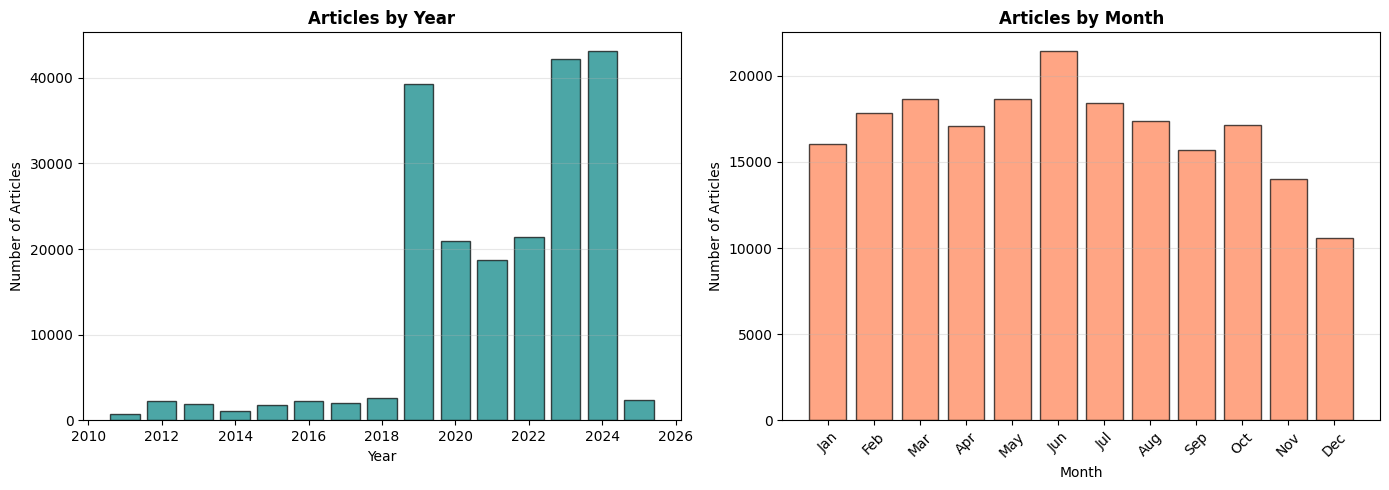


Saved visualization: json_temporal_analysis.png


7423

In [42]:
print("TEMPORAL COVERAGE ANALYSIS")

df_articles['parsed_date'] = df_articles['date'].apply(parse_date_safe)
df_valid_dates = df_articles[df_articles['parsed_date'].notna()].copy()

print(f"\nDate Parsing:")
print(f"  Valid dates: {len(df_valid_dates)} ({len(df_valid_dates)/len(df_articles)*100:.1f}%)")
print(f"  Invalid dates: {len(df_articles) - len(df_valid_dates)} ({(len(df_articles) - len(df_valid_dates))/len(df_articles)*100:.1f}%)")

if len(df_valid_dates) > 0:
    print(f"\nDate Range:")
    print(f"  Earliest: {df_valid_dates['parsed_date'].min()}")
    print(f"  Latest: {df_valid_dates['parsed_date'].max()}")
    
    df_valid_dates['year'] = df_valid_dates['parsed_date'].dt.year
    df_valid_dates['month'] = df_valid_dates['parsed_date'].dt.month
    
    year_counts = df_valid_dates['year'].value_counts().sort_index()
    
    print(f"\nArticles by Year:")
    for year, count in year_counts.items():
        print(f"  {year}: {count}")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].bar(year_counts.index, year_counts.values, color='teal', edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Number of Articles')
    axes[0].set_title('Articles by Year', fontweight='bold')
    axes[0].grid(alpha=0.3, axis='y')
    
    month_counts = df_valid_dates['month'].value_counts().sort_index()
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    axes[1].bar(month_counts.index, month_counts.values, color='coral', edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Month')
    axes[1].set_ylabel('Number of Articles')
    axes[1].set_title('Articles by Month', fontweight='bold')
    axes[1].set_xticks(range(1, 13))
    axes[1].set_xticklabels(month_names, rotation=45)
    axes[1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('json_temporal_analysis.png', dpi=CONFIG.DPI, bbox_inches='tight')
    plt.show()
    
    print(f"\nSaved visualization: json_temporal_analysis.png")
    
    del fig, axes


gc.collect()


## 5. URL and Domain Analysis

URL AND DOMAIN ANALYSIS

Top 10 Domains:
  www.theguardian.com: 178603 (88.1%)
  www.cnn.com: 24200 (11.9%)


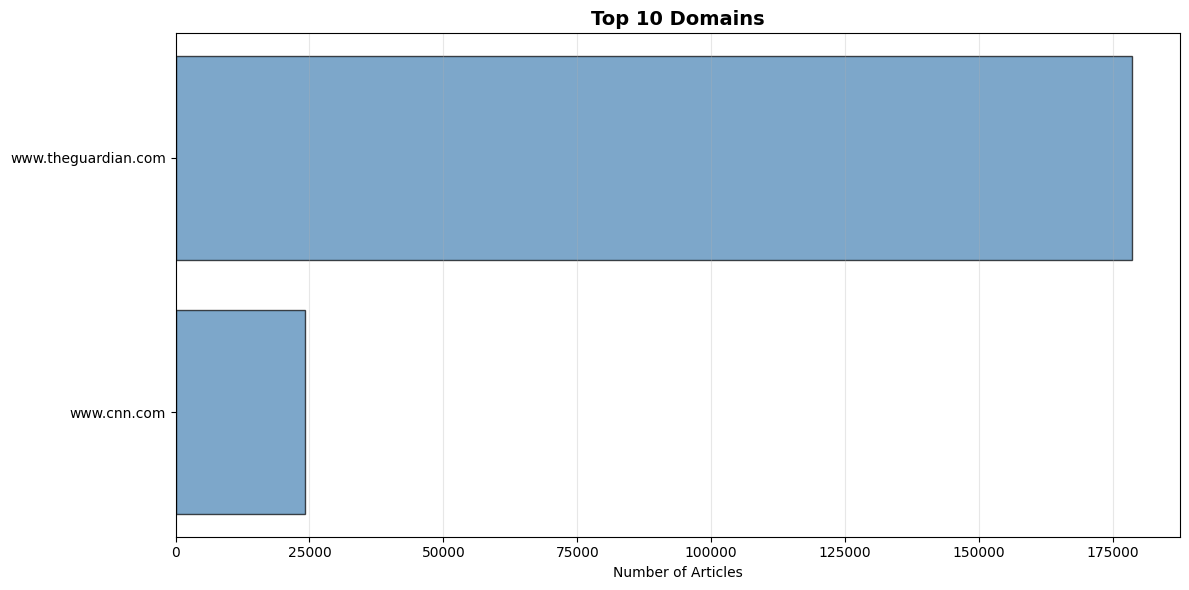


Saved visualization: json_domain_analysis.png


2614

In [43]:
print("URL AND DOMAIN ANALYSIS")

df_articles['domain'] = df_articles['url'].apply(extract_domain)

domain_counts = df_articles['domain'].value_counts()
print(f"\nTop 10 Domains:")
for domain, count in domain_counts.head(10).items():
    pct = (count / len(df_articles)) * 100
    print(f"  {domain}: {count} ({pct:.1f}%)")

plt.figure(figsize=(12, 6))
top_domains = domain_counts.head(10)
plt.barh(range(len(top_domains)), top_domains.values, color='steelblue', edgecolor='black', alpha=0.7)
plt.yticks(range(len(top_domains)), top_domains.index)
plt.xlabel('Number of Articles')
plt.title('Top 10 Domains', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('json_domain_analysis.png', dpi=CONFIG.DPI, bbox_inches='tight')
plt.show()

print(f"\nSaved visualization: json_domain_analysis.png")

gc.collect()


## 6. Images per Article Analysis

In [44]:
print("IMAGES PER ARTICLE ANALYSIS")

print(f"\nImages per Article Statistics:")
print(f"  Min: {df_articles['num_images'].min()}")
print(f"  Max: {df_articles['num_images'].max()}")
print(f"  Mean: {df_articles['num_images'].mean():.2f}")
print(f"  Median: {df_articles['num_images'].median():.1f}")

articles_with_no_images = (df_articles['num_images'] == 0).sum()
print(f"\nArticles with no images: {articles_with_no_images} ({articles_with_no_images/len(df_articles)*100:.1f}%)")


gc.collect()

IMAGES PER ARTICLE ANALYSIS

Images per Article Statistics:
  Min: 0
  Max: 228
  Mean: 2.05
  Median: 1.0

Articles with no images: 10484 (5.2%)


0

## 7. Text Content Analysis

TEXT CONTENT ANALYSIS

Analyzing text content patterns...

Word Count Statistics:
  Title:
    Min: 0
    Max: 33
    Mean: 11.7
    Median: 12.0

  Content:
    Min: 0
    Max: 12369
    Mean: 824.3
    Median: 727.0

Sentence Statistics:
  Avg sentences per article: 38.1
  Avg words per sentence: 23.1

Vocabulary Statistics:
  Total words: 167172324
  Unique words: 535902
  Vocabulary richness: 0.0032

Top 20 Most Common Words:
  1. the: 9944866
  2. to: 4762421
  3. of: 4345121
  4. and: 4081396
  5. a: 3993592
  6. in: 3588829
  7. s: 2008023
  8. that: 1794885
  9. for: 1643341
  10. on: 1524480
  11. is: 1511850
  12. it: 1457427
  13. was: 1258970
  14. with: 1167726
  15. as: 1063813
  16. he: 1003450
  17. at: 911538
  18. said: 906967
  19. i: 841618
  20. have: 827120

Top 10 Bigrams:
  1. 'of the': 4727
  2. 'in the': 4119
  3. 'to the': 2115
  4. 'on the': 1661
  5. 'at the': 1465
  6. 'for the': 1444
  7. 'and the': 1328
  8. 'to be': 1327
  9. 'it s': 1268
  10. 'in a': 

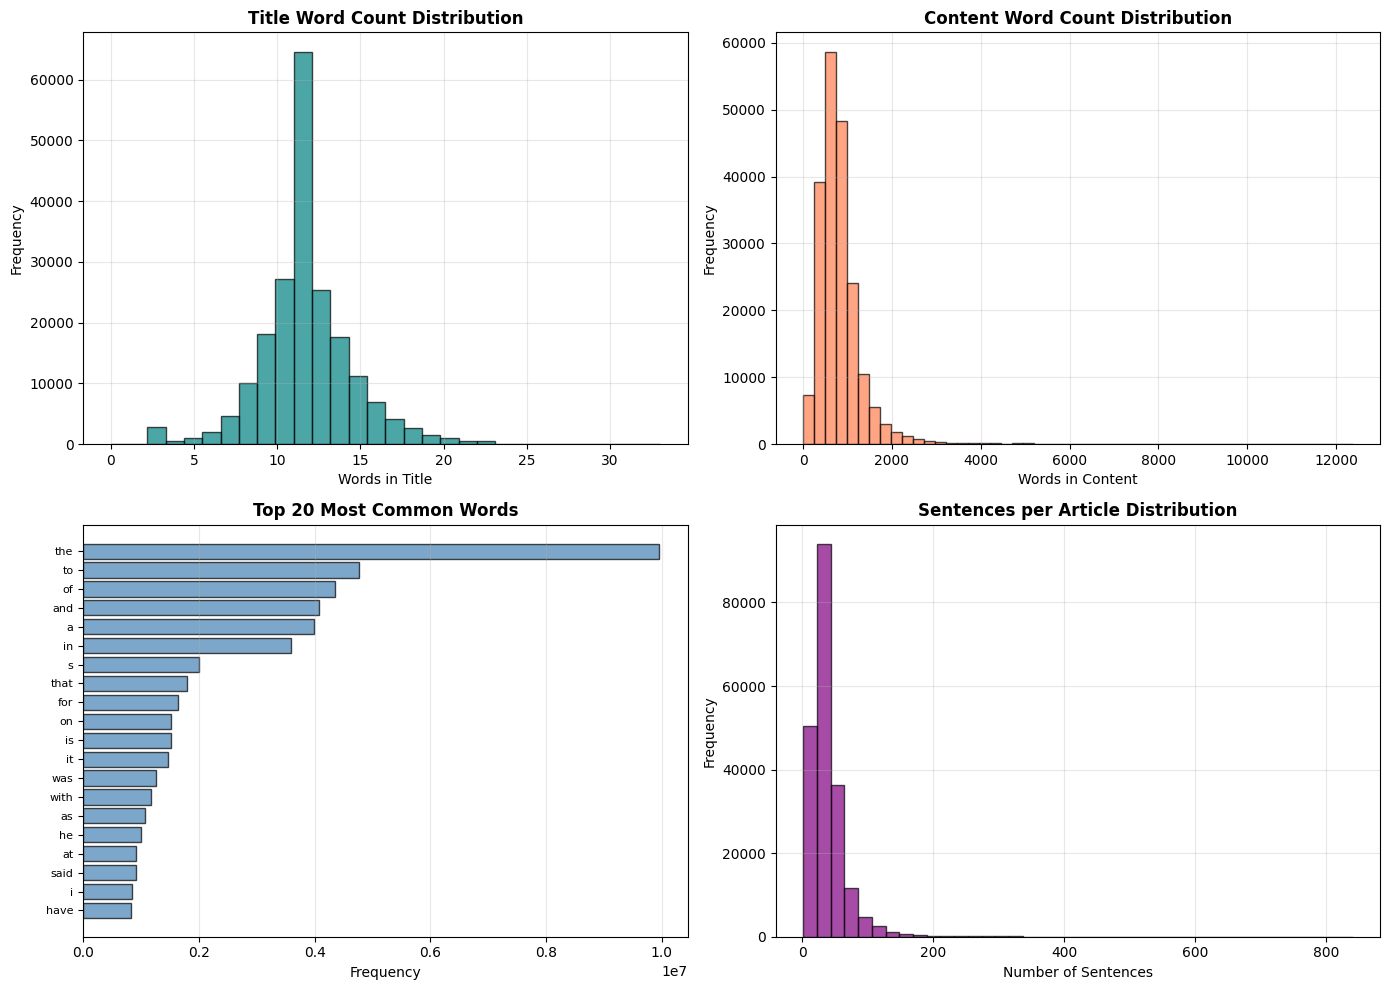


Saved visualization: json_text_content_analysis.png


19417

In [45]:
print("TEXT CONTENT ANALYSIS")

print("\nAnalyzing text content patterns...")

df_articles['title_words'] = df_articles['title'].apply(simple_tokenize)
df_articles['content_words'] = df_articles['content'].apply(simple_tokenize)
df_articles['title_word_count'] = df_articles['title_words'].apply(len)
df_articles['content_word_count'] = df_articles['content_words'].apply(len)
df_articles['content_sentence_count'] = df_articles['content'].apply(compute_sentence_count)

print(f"\nWord Count Statistics:")
print(f"  Title:")
print(f"    Min: {df_articles['title_word_count'].min()}")
print(f"    Max: {df_articles['title_word_count'].max()}")
print(f"    Mean: {df_articles['title_word_count'].mean():.1f}")
print(f"    Median: {df_articles['title_word_count'].median():.1f}")

print(f"\n  Content:")
print(f"    Min: {df_articles['content_word_count'].min()}")
print(f"    Max: {df_articles['content_word_count'].max()}")
print(f"    Mean: {df_articles['content_word_count'].mean():.1f}")
print(f"    Median: {df_articles['content_word_count'].median():.1f}")

print(f"\nSentence Statistics:")
print(f"  Avg sentences per article: {df_articles['content_sentence_count'].mean():.1f}")
print(f"  Avg words per sentence: {(df_articles['content_word_count'] / df_articles['content_sentence_count']).mean():.1f}")

all_content_words = []
for words in df_articles['content_words']:
    all_content_words.extend(words)

word_freq = Counter(all_content_words)
top_100_words = word_freq.most_common(100)

print(f"\nVocabulary Statistics:")
print(f"  Total words: {len(all_content_words)}")
print(f"  Unique words: {len(word_freq)}")
print(f"  Vocabulary richness: {len(word_freq)/len(all_content_words):.4f}")

print(f"\nTop 20 Most Common Words:")
for idx, (word, count) in enumerate(top_100_words[:20], 1):
    print(f"  {idx}. {word}: {count}")

all_bigrams = []
for words in df_articles['content_words'].sample(min(1000, len(df_articles))):
    if len(words) > 1:
        all_bigrams.extend(extract_ngrams(words, 2))

bigram_freq = Counter(all_bigrams)
top_bigrams = bigram_freq.most_common(10)

print(f"\nTop 10 Bigrams:")
for idx, (bigram, count) in enumerate(top_bigrams, 1):
    print(f"  {idx}. '{bigram}': {count}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(df_articles['title_word_count'], bins=30, color='teal', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Words in Title')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Title Word Count Distribution', fontweight='bold')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist(df_articles['content_word_count'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Words in Content')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Content Word Count Distribution', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

top_20_labels = [word for word, _ in top_100_words[:20]]
top_20_counts = [count for _, count in top_100_words[:20]]
axes[1, 0].barh(range(len(top_20_labels)), top_20_counts, color='steelblue', edgecolor='black', alpha=0.7)
axes[1, 0].set_yticks(range(len(top_20_labels)))
axes[1, 0].set_yticklabels(top_20_labels, fontsize=8)
axes[1, 0].set_xlabel('Frequency')
axes[1, 0].set_title('Top 20 Most Common Words', fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(alpha=0.3, axis='x')

axes[1, 1].hist(df_articles['content_sentence_count'], bins=40, color='purple', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Number of Sentences')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Sentences per Article Distribution', fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('json_text_content_analysis.png', dpi=CONFIG.DPI, bbox_inches='tight')
plt.show()

print(f"\nSaved visualization: json_text_content_analysis.png")

del fig, axes
gc.collect()


## 8. Named Entity Patterns

In [46]:
print("NAMED ENTITY PATTERNS (RULE-BASED)")

print("\nExtracting capitalized words as potential entities...")

df_articles['title_entities'] = df_articles['title'].apply(extract_capitalized_words)
df_articles['content_entities'] = df_articles['content'].apply(extract_capitalized_words)
df_articles['title_entity_count'] = df_articles['title_entities'].apply(len)
df_articles['content_entity_count'] = df_articles['content_entities'].apply(len)

print(f"\nEntity Count Statistics:")
print(f"  Title entities:")
print(f"    Mean: {df_articles['title_entity_count'].mean():.1f}")
print(f"    Median: {df_articles['title_entity_count'].median():.1f}")
print(f"\n  Content entities:")
print(f"    Mean: {df_articles['content_entity_count'].mean():.1f}")
print(f"    Median: {df_articles['content_entity_count'].median():.1f}")

all_title_entities = []
for entities in df_articles['title_entities']:
    all_title_entities.extend(entities)

all_content_entities = []
for entities in df_articles['content_entities']:
    all_content_entities.extend(entities)

title_entity_freq = Counter(all_title_entities)
content_entity_freq = Counter(all_content_entities)

print(f"\nTop 15 Entities in Titles:")
for idx, (entity, count) in enumerate(title_entity_freq.most_common(15), 1):
    print(f"  {idx}. {entity}: {count}")

print(f"\nTop 15 Entities in Content:")
for idx, (entity, count) in enumerate(content_entity_freq.most_common(15), 1):
    print(f"  {idx}. {entity}: {count}")

gc.collect()

NAMED ENTITY PATTERNS (RULE-BASED)

Extracting capitalized words as potential entities...

Entity Count Statistics:
  Title entities:
    Mean: 2.7
    Median: 2.0

  Content entities:
    Mean: 109.3
    Median: 89.0

Top 15 Entities in Titles:
  1. The: 9591
  2. England: 6300
  3. Trump: 5320
  4. Covid: 5019
  5. Australia: 4322
  6. Cup: 3654
  7. New: 3170
  8. World: 3079
  9. How: 2811
  10. Australian: 2781
  11. Manchester: 2734
  12. Ukraine: 2685
  13. It: 2407
  14. League: 2374
  15. Brexit: 2340

Top 15 Entities in Content:
  1. The: 1119445
  2. It: 385345
  3. In: 250006
  4. But: 228259
  5. He: 227297
  6. We: 227077
  7. This: 142832
  8. There: 123497
  9. They: 117404
  10. Photos: 117105
  11. Trump: 112736
  12. Australia: 106174
  13. And: 105630
  14. Caption: 103510
  15. Hide: 100727


0

## 9. Article Category Inference

ARTICLE CATEGORY INFERENCE

Inferring categories from keywords...

Inferred Category Distribution:
  Politics: 71901 (35.5%)
  Sports: 48448 (23.9%)
  Business: 24843 (12.2%)
  Health: 24411 (12.0%)
  Entertainment: 16286 (8.0%)
  Unknown: 11420 (5.6%)
  Technology: 5494 (2.7%)


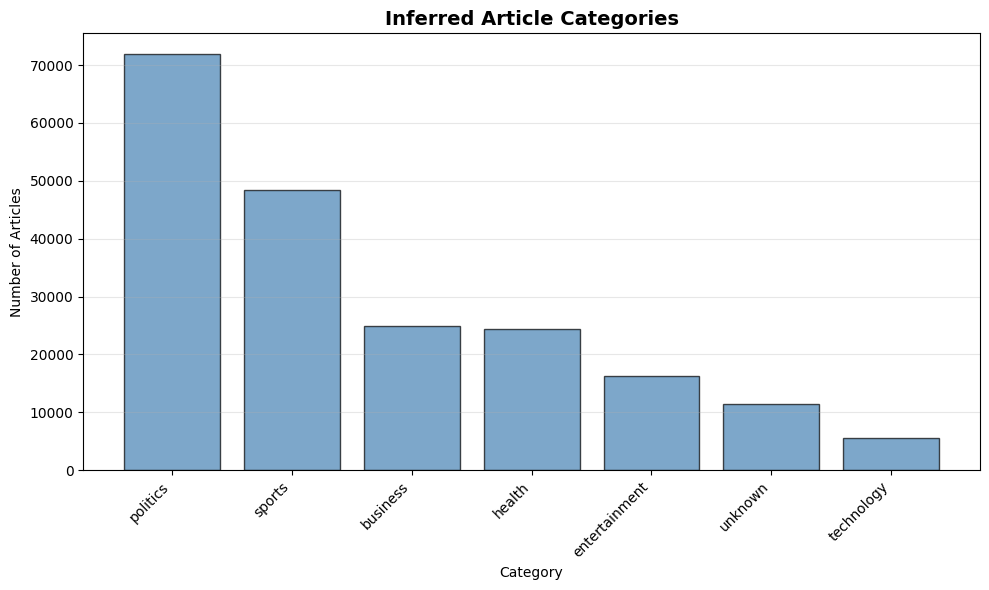


Saved visualization: json_category_inference.png


3323

In [47]:
print("ARTICLE CATEGORY INFERENCE")

print("\nInferring categories from keywords...")

category_keywords = {
    'politics': ['government', 'president', 'election', 'congress', 'senate', 'vote', 'minister', 'political'],
    'sports': ['game', 'team', 'player', 'match', 'tournament', 'win', 'score', 'league', 'coach'],
    'business': ['company', 'market', 'stock', 'economy', 'business', 'trade', 'ceo', 'profit', 'investment'],
    'technology': ['tech', 'software', 'digital', 'data', 'computer', 'internet', 'ai', 'robot', 'innovation'],
    'health': ['health', 'medical', 'hospital', 'doctor', 'patient', 'disease', 'treatment', 'covid', 'pandemic'],
    'entertainment': ['movie', 'film', 'music', 'celebrity', 'actor', 'show', 'entertainment', 'star']
}

def infer_category(content_words):
    if not content_words:
        return 'unknown'
    
    category_scores = defaultdict(int)
    content_set = set(content_words)
    
    for category, keywords in category_keywords.items():
        for keyword in keywords:
            if keyword in content_set:
                category_scores[category] += 1
    
    if not category_scores:
        return 'unknown'
    
    return max(category_scores.items(), key=lambda x: x[1])[0]

df_articles['inferred_category'] = df_articles['content_words'].apply(infer_category)

category_counts = df_articles['inferred_category'].value_counts()

print(f"\nInferred Category Distribution:")
for category, count in category_counts.items():
    pct = (count / len(df_articles)) * 100
    print(f"  {category.capitalize()}: {count} ({pct:.1f}%)")

plt.figure(figsize=(10, 6))
plt.bar(category_counts.index, category_counts.values, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.title('Inferred Article Categories', fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('json_category_inference.png', dpi=CONFIG.DPI, bbox_inches='tight')
plt.show()

print(f"\nSaved visualization: json_category_inference.png")

gc.collect()

## 10. Outlier Detection

In [50]:
print("OUTLIER DETECTION")

print("\nIdentifying outlier articles...")

long_titles = df_articles[df_articles['title_length'] > 150]
short_content = df_articles[df_articles['content_length'] < 500]
long_content = df_articles[df_articles['content_length'] > 20000]

print(f"\nTitle Outliers:")
print(f"  Unusually long titles (>150 chars): {len(long_titles)} ({len(long_titles)/len(df_articles)*100:.2f}%)")
if len(long_titles) > 0:
    print(f"    Longest: {long_titles['title_length'].max()} chars")
    print(f"    Sample: {long_titles.iloc[0]['title'][:100]}...")

print(f"\nContent Outliers:")
print(f"  Unusually short content (<500 chars): {len(short_content)} ({len(short_content)/len(df_articles)*100:.2f}%)")
if len(short_content) > 0:
    print(f"    Shortest: {short_content['content_length'].min()} chars")

print(f"  Unusually long content (>20000 chars): {len(long_content)} ({len(long_content)/len(df_articles)*100:.2f}%)")
if len(long_content) > 0:
    print(f"    Longest: {long_content['content_length'].max()} chars")

if 'parsed_date' in df_articles.columns and df_articles['parsed_date'].notna().sum() > 0:
    import pytz
    current_date = pd.Timestamp('2025-10-19', tz='UTC')
    
    df_with_dates = df_articles[df_articles['parsed_date'].notna()].copy()
    if df_with_dates['parsed_date'].dt.tz is None:
        df_with_dates['parsed_date'] = df_with_dates['parsed_date'].dt.tz_localize('UTC')
    else:
        df_with_dates['parsed_date'] = df_with_dates['parsed_date'].dt.tz_convert('UTC')
    
    future_dates = df_with_dates[df_with_dates['parsed_date'] > current_date]
    very_old_dates = df_with_dates[df_with_dates['parsed_date'].dt.year < 2000]
    
    print(f"\nDate Anomalies:")
    print(f"  Future dates: {len(future_dates)} ({len(future_dates)/len(df_articles)*100:.2f}%)")
    if len(future_dates) > 0:
        print(f"    Latest future date: {future_dates['parsed_date'].max()}")
    print(f"  Very old dates (<2000): {len(very_old_dates)} ({len(very_old_dates)/len(df_articles)*100:.2f}%)")
    if len(very_old_dates) > 0:
        print(f"    Oldest date: {very_old_dates['parsed_date'].min()}")

gc.collect()


OUTLIER DETECTION

Identifying outlier articles...

Title Outliers:
  Unusually long titles (>150 chars): 49 (0.02%)
    Longest: 211 chars
    Sample: Daniel Ricciardo: From withstanding searing heat to 'fighting tension in the body,' how F1 star's pe...

Content Outliers:
  Unusually short content (<500 chars): 361 (0.18%)
    Shortest: 5 chars
  Unusually long content (>20000 chars): 1266 (0.62%)
    Longest: 74431 chars

Date Anomalies:
  Future dates: 0 (0.00%)
  Very old dates (<2000): 0 (0.00%)


23

## 11. Source Bias Deep Dive

SOURCE BIAS DEEP DIVE

Comparing major news sources...

www.theguardian.com:
  Article count: 178603
  Avg content length: 4783 chars
  Avg images per article: 1.82
  Date range: 2019-01-01 00:01:04+00:00 to 2025-02-14 23:14:34+00:00

www.cnn.com:
  Article count: 24200
  Avg content length: 5856 chars
  Avg images per article: 3.74
  Date range: 2011-08-24 17:54:07+00:00 to 2022-03-21 11:00:23+00:00


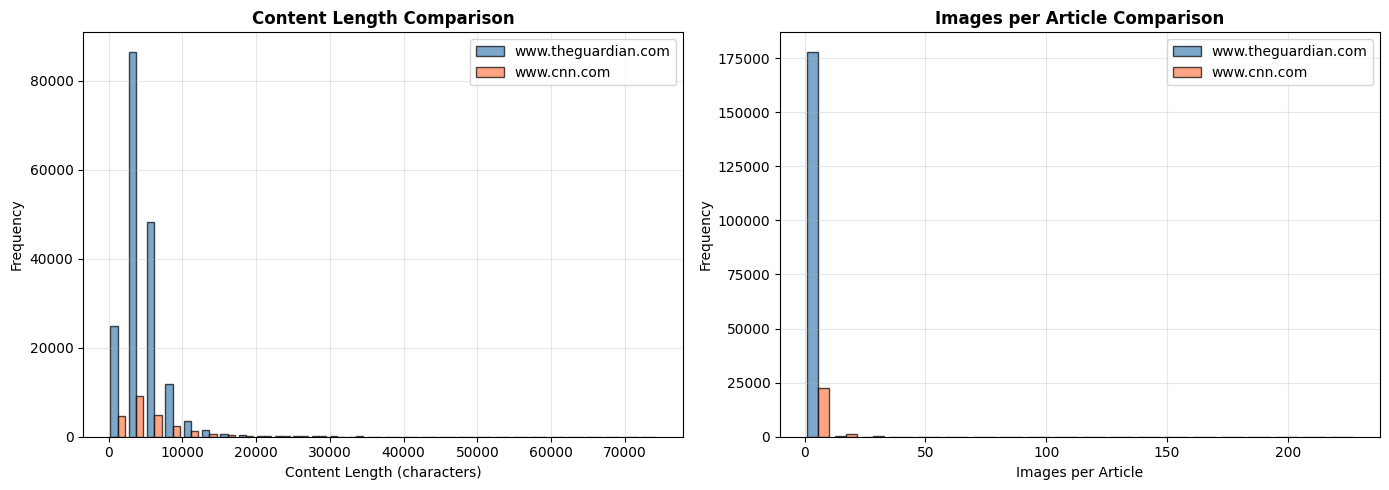


Saved visualization: json_source_comparison.png


11355

In [51]:
print("SOURCE BIAS DEEP DIVE")

print("\nComparing major news sources...")

top_domains = df_articles['domain'].value_counts().head(5).index.tolist()

for domain in top_domains:
    domain_articles = df_articles[df_articles['domain'] == domain]
    print(f"\n{domain}:")
    print(f"  Article count: {len(domain_articles)}")
    print(f"  Avg content length: {domain_articles['content_length'].mean():.0f} chars")
    print(f"  Avg images per article: {domain_articles['num_images'].mean():.2f}")
    if 'parsed_date' in domain_articles.columns and domain_articles['parsed_date'].notna().sum() > 0:
        print(f"  Date range: {domain_articles['parsed_date'].min()} to {domain_articles['parsed_date'].max()}")

if len(top_domains) >= 2:
    domain1 = top_domains[0]
    domain2 = top_domains[1]
    
    domain1_articles = df_articles[df_articles['domain'] == domain1]
    domain2_articles = df_articles[df_articles['domain'] == domain2]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].hist([domain1_articles['content_length'], domain2_articles['content_length']], 
                 bins=30, label=[domain1, domain2], color=['steelblue', 'coral'], 
                 edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Content Length (characters)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Content Length Comparison', fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    axes[1].hist([domain1_articles['num_images'], domain2_articles['num_images']], 
                 bins=20, label=[domain1, domain2], color=['steelblue', 'coral'], 
                 edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Images per Article')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Images per Article Comparison', fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('json_source_comparison.png', dpi=CONFIG.DPI, bbox_inches='tight')
    plt.show()
    
    print(f"\nSaved visualization: json_source_comparison.png")
    
    del fig, axes


gc.collect()


## 12. Caption Dataset Analysis

CAPTION DATASET ANALYSIS (RETRIEVAL QUERIES)

Analyzing article titles as retrieval queries...

Query Statistics (Article Titles):
  Total queries: 202803

  Query length (chars):
    Min: 4
    Max: 211
    Mean: 71.8
    Median: 71.0

  Query word count:
    Min: 0
    Max: 33
    Mean: 11.7
    Median: 12.0

  Query vocabulary size: 60760
  Total words in queries: 2367953
  Vocabulary richness: 0.0257

Retrieval Task Setup:
  Queries (articles): 202803
  Total images available: 416249
  Avg images per query: 2.05
  Articles with no images: 10484

  Valid query-image pairs: 192319
  Total retrievable images: 416249


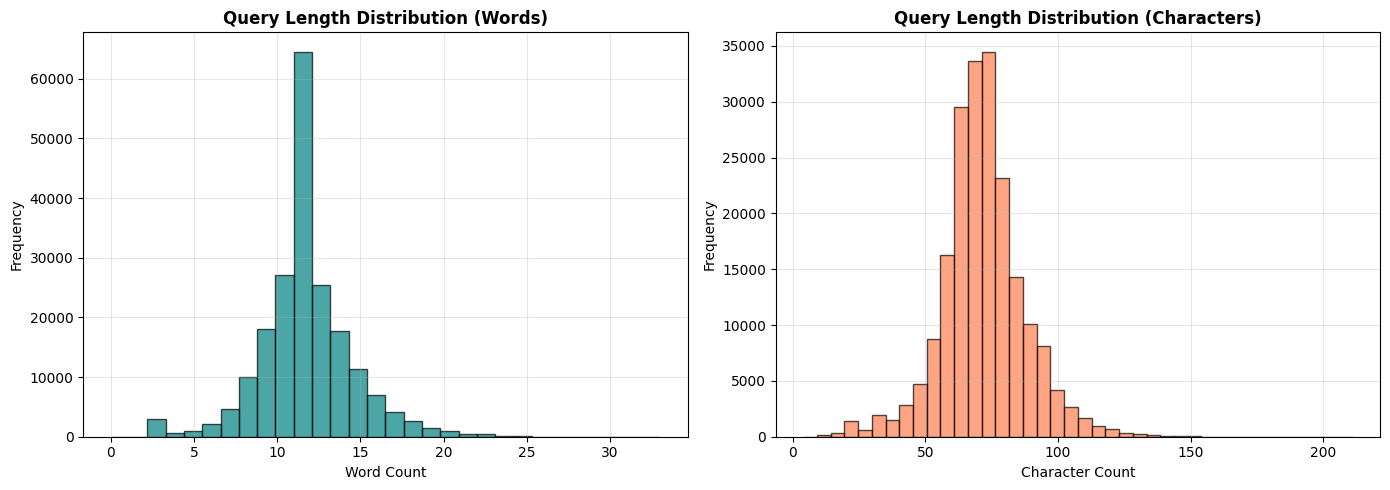


Saved visualization: json_retrieval_query_analysis.png


39

In [54]:
print("CAPTION DATASET ANALYSIS (RETRIEVAL QUERIES)")

print("\nAnalyzing article titles as retrieval queries...")

df_articles['title_char_length'] = df_articles['title'].str.len()
df_articles['title_word_count'] = df_articles['title_words'].apply(len)

print(f"\nQuery Statistics (Article Titles):")
print(f"  Total queries: {len(df_articles)}")

print(f"\n  Query length (chars):")
print(f"    Min: {df_articles['title_char_length'].min()}")
print(f"    Max: {df_articles['title_char_length'].max()}")
print(f"    Mean: {df_articles['title_char_length'].mean():.1f}")
print(f"    Median: {df_articles['title_char_length'].median():.1f}")

print(f"\n  Query word count:")
print(f"    Min: {df_articles['title_word_count'].min()}")
print(f"    Max: {df_articles['title_word_count'].max()}")
print(f"    Mean: {df_articles['title_word_count'].mean():.1f}")
print(f"    Median: {df_articles['title_word_count'].median():.1f}")

all_title_words = []
for words in df_articles['title_words']:
    all_title_words.extend(words)

title_vocab = set(all_title_words)
print(f"\n  Query vocabulary size: {len(title_vocab)}")
print(f"  Total words in queries: {len(all_title_words)}")
print(f"  Vocabulary richness: {len(title_vocab)/len(all_title_words):.4f}")

print(f"\nRetrieval Task Setup:")
print(f"  Queries (articles): {len(df_articles)}")
print(f"  Total images available: {df_articles['num_images'].sum()}")
print(f"  Avg images per query: {df_articles['num_images'].mean():.2f}")
print(f"  Articles with no images: {(df_articles['num_images'] == 0).sum()}")

queries_with_images = df_articles[df_articles['num_images'] > 0]
print(f"\n  Valid query-image pairs: {len(queries_with_images)}")
print(f"  Total retrievable images: {queries_with_images['num_images'].sum()}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_articles['title_word_count'], bins=30, color='teal', 
             edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Query Length Distribution (Words)', fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].hist(df_articles['title_char_length'], bins=40, color='coral', 
             edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Character Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Query Length Distribution (Characters)', fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('json_retrieval_query_analysis.png', dpi=CONFIG.DPI, bbox_inches='tight')
plt.show()

print(f"\nSaved visualization: json_retrieval_query_analysis.png")

gc.collect()


## 13. Summary Report

In [55]:
print("COMPLETE JSON EDA SUMMARY REPORT")

print(f"\nDataset Overview:")
print(f"  Total articles: {len(df_articles)}")
print(f"  Unique IDs: {df_articles['id'].nunique()}")
if 'parsed_date' in df_articles.columns and df_articles['parsed_date'].notna().sum() > 0:
    print(f"  Date range: {df_articles['parsed_date'].min()} to {df_articles['parsed_date'].max()}")

print(f"\nText Statistics:")
print(f"  Avg title length: {df_articles['title_length'].mean():.0f} chars ({df_articles['title_word_count'].mean():.1f} words)")
print(f"  Avg content length: {df_articles['content_length'].mean():.0f} chars ({df_articles['content_word_count'].mean():.1f} words)")
print(f"  Avg sentences per article: {df_articles['content_sentence_count'].mean():.1f}")
print(f"  Vocabulary richness: {len(word_freq)/len(all_content_words):.4f}")

print(f"\nEntity Patterns:")
print(f"  Avg entities in title: {df_articles['title_entity_count'].mean():.1f}")
print(f"  Avg entities in content: {df_articles['content_entity_count'].mean():.1f}")

print(f"\nCategory Distribution:")
for category, count in category_counts.head(5).items():
    print(f"  {category.capitalize()}: {count} ({count/len(df_articles)*100:.1f}%)")

print(f"\nImage Coverage:")
print(f"  Total images referenced: {df_articles['num_images'].sum()}")
print(f"  Avg images per article: {df_articles['num_images'].mean():.2f}")

print(f"\nOutliers:")
print(f"  Long titles (>150 chars): {len(long_titles)}")
print(f"  Short content (<500 chars): {len(short_content)}")
print(f"  Long content (>20000 chars): {len(long_content)}")

print(f"\nTop Sources:")
for domain, count in domain_counts.head(3).items():
    print(f"  {domain}: {count} articles")

if caption_data:
    print(f"\nCaption Datasets:")
    for name, captions in caption_data.items():
        print(f"  {name}: {len(captions)} captions")


COMPLETE JSON EDA SUMMARY REPORT

Dataset Overview:
  Total articles: 202803
  Unique IDs: 202803
  Date range: 2011-08-24 17:54:07+00:00 to 2025-02-14 23:14:34+00:00

Text Statistics:
  Avg title length: 72 chars (11.7 words)
  Avg content length: 4911 chars (824.3 words)
  Avg sentences per article: 38.1
  Vocabulary richness: 0.0032

Entity Patterns:
  Avg entities in title: 2.7
  Avg entities in content: 109.3

Category Distribution:
  Politics: 71901 (35.5%)
  Sports: 48448 (23.9%)
  Business: 24843 (12.2%)
  Health: 24411 (12.0%)
  Entertainment: 16286 (8.0%)

Image Coverage:
  Total images referenced: 416249
  Avg images per article: 2.05

Outliers:
  Long titles (>150 chars): 49
  Short content (<500 chars): 361
  Long content (>20000 chars): 1266

Top Sources:
  www.theguardian.com: 178603 articles
  www.cnn.com: 24200 articles


# IMAGE-JSON-CAPTION

## 1. Referential Integrity Check

In [56]:
print("REFERENTIAL INTEGRITY: JSON-IMAGE LINKAGE")

print("\nValidating JSON references to images...")

image_dir = Path(CONFIG.IMAGE_DIR)
available_images = set([f.stem for f in image_dir.glob("*.*")])

print(f"\nAvailable images on disk: {len(available_images)}")

referenced_images = set()
articles_with_missing_images = []
total_references = 0
missing_references = 0

for article_id, article_data in root_data.items():
    images = article_data.get('images', [])
    for img_ref in images:
        total_references += 1
        img_name = Path(img_ref).stem
        referenced_images.add(img_name)
        
        if img_name not in available_images:
            missing_references += 1
            articles_with_missing_images.append(article_id)

orphaned_images = available_images - referenced_images

print(f"\nReferential Integrity Report:")
print(f"  Total image references in JSON: {total_references}")
print(f"  Unique images referenced: {len(referenced_images)}")
print(f"  Missing images (referenced but not on disk): {missing_references} ({missing_references/total_references*100:.2f}%)")
print(f"  Orphaned images (on disk but not referenced): {len(orphaned_images)} ({len(orphaned_images)/len(available_images)*100:.2f}%)")
print(f"  Articles with missing images: {len(set(articles_with_missing_images))}")

print(f"\nCoverage Statistics:")
articles_with_images = sum(1 for a in root_data.values() if len(a.get('images', [])) > 0)
print(f"  Articles with ≥1 image: {articles_with_images} ({articles_with_images/len(root_data)*100:.1f}%)")
print(f"  Images per article (mean): {total_references/len(root_data):.2f}")


gc.collect()

REFERENTIAL INTEGRITY: JSON-IMAGE LINKAGE

Validating JSON references to images...

Available images on disk: 415309

Referential Integrity Report:
  Total image references in JSON: 416249
  Unique images referenced: 416249
  Missing images (referenced but not on disk): 940 (0.23%)
  Orphaned images (on disk but not referenced): 0 (0.00%)
  Articles with missing images: 254

Coverage Statistics:
  Articles with ≥1 image: 192319 (94.8%)
  Images per article (mean): 2.05


0

## 2. Article-as-Caption Analysis

ARTICLE TITLES AS CAPTIONS (RETRIEVAL QUERIES)

Analyzing article titles as retrieval captions...

Caption Statistics (Article Titles as Queries):
  Total captions: 5000

  Caption length (characters):
    Min: 14
    Max: 150
    Mean: 72.0
    Median: 72.0

  Caption word count:
    Min: 2
    Max: 28
    Mean: 11.7
    Median: 12.0

  Caption vocabulary size: 11665
  Total words in captions: 58606
  Vocabulary richness: 0.1990

Top 15 Most Frequent Caption Words:
  1. to: 1726
  2. the: 1219
  3. in: 1205
  4. of: 1172
  5. s: 1083
  6. and: 766
  7. for: 749
  8. a: 653
  9. on: 546
  10. cnn: 506
  11. as: 407
  12. after: 351
  13. at: 321
  14. with: 317
  15. is: 308


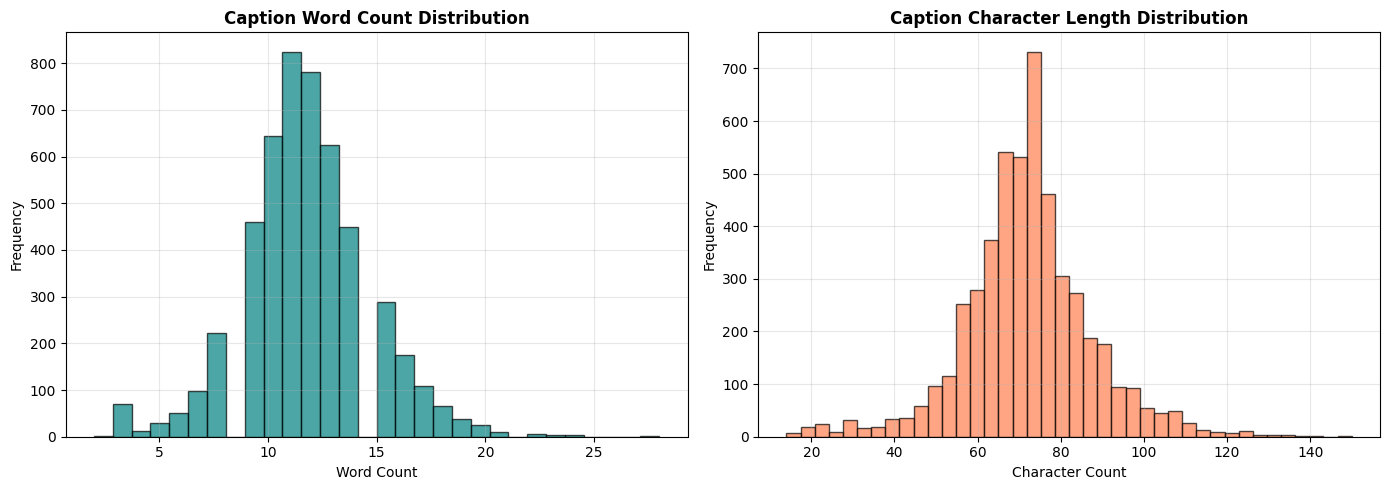


Saved visualization: crossmodal_caption_analysis.png


19175

In [57]:
print("ARTICLE TITLES AS CAPTIONS (RETRIEVAL QUERIES)")

print("\nAnalyzing article titles as retrieval captions...")

sample_size = min(5000, len(df_articles))
df_sample = df_articles.sample(sample_size, random_state=CONFIG.RANDOM_SEED)

df_sample['caption'] = df_sample['title']
df_sample['caption_words'] = df_sample['title_words']
df_sample['caption_word_count'] = df_sample['caption_words'].apply(len)
df_sample['caption_char_length'] = df_sample['caption'].str.len()

print(f"\nCaption Statistics (Article Titles as Queries):")
print(f"  Total captions: {len(df_sample)}")

print(f"\n  Caption length (characters):")
print(f"    Min: {df_sample['caption_char_length'].min()}")
print(f"    Max: {df_sample['caption_char_length'].max()}")
print(f"    Mean: {df_sample['caption_char_length'].mean():.1f}")
print(f"    Median: {df_sample['caption_char_length'].median():.1f}")

print(f"\n  Caption word count:")
print(f"    Min: {df_sample['caption_word_count'].min()}")
print(f"    Max: {df_sample['caption_word_count'].max()}")
print(f"    Mean: {df_sample['caption_word_count'].mean():.1f}")
print(f"    Median: {df_sample['caption_word_count'].median():.1f}")

all_caption_words = []
for words in df_sample['caption_words']:
    all_caption_words.extend(words)

caption_vocab = set(all_caption_words)
print(f"\n  Caption vocabulary size: {len(caption_vocab)}")
print(f"  Total words in captions: {len(all_caption_words)}")
print(f"  Vocabulary richness: {len(caption_vocab)/len(all_caption_words):.4f}")

caption_word_freq = Counter(all_caption_words)
print(f"\nTop 15 Most Frequent Caption Words:")
for idx, (word, count) in enumerate(caption_word_freq.most_common(15), 1):
    print(f"  {idx}. {word}: {count}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_sample['caption_word_count'], bins=30, color='teal', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Caption Word Count Distribution', fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].hist(df_sample['caption_char_length'], bins=40, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Character Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Caption Character Length Distribution', fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('crossmodal_caption_analysis.png', dpi=CONFIG.DPI, bbox_inches='tight')
plt.show()

print(f"\nSaved visualization: crossmodal_caption_analysis.png")

del fig, axes
gc.collect()

## 3. Caption-Article Content Overlap

CAPTION-ARTICLE CONTENT OVERLAP

Analyzing word overlap between captions and article content...

Caption-Content Overlap Statistics:
  Word overlap (absolute):
    Mean: 9.24 words
    Median: 9.0 words
    Max: 22 words

  Jaccard similarity:
    Mean: 0.0287
    Median: 0.0262
    Max: 0.2131

Caption Type Analysis:
  Highly extractive (≥80% overlap): 571 (57.1%)
  Highly abstractive (<50% overlap): 21 (2.1%)


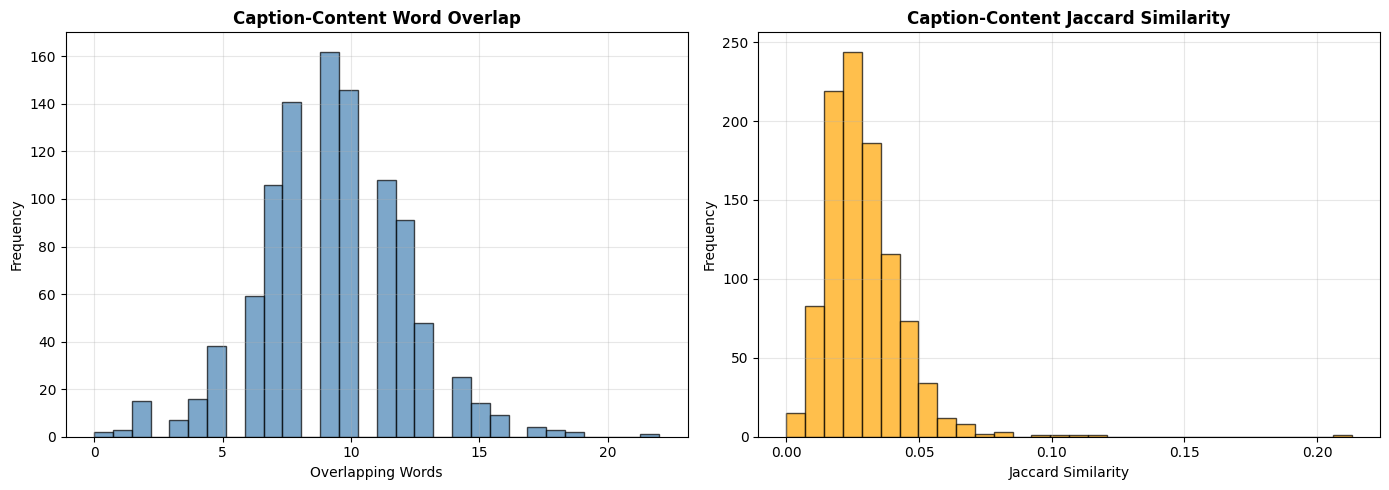


Saved visualization: crossmodal_caption_overlap.png


8796

In [58]:
print("CAPTION-ARTICLE CONTENT OVERLAP")

print("\nAnalyzing word overlap between captions and article content...")

def jaccard_similarity(set1, set2):
    if not set1 or not set2:
        return 0.0
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0.0

overlap_sample_size = min(1000, len(df_sample))
overlap_sample = df_sample.sample(overlap_sample_size, random_state=CONFIG.RANDOM_SEED)

caption_content_overlaps = []
caption_content_jaccard = []

for idx, row in overlap_sample.iterrows():
    caption_set = set(row['caption_words'])
    content_set = set(row['content_words'])
    
    overlap = len(caption_set.intersection(content_set))
    caption_content_overlaps.append(overlap)
    
    jaccard = jaccard_similarity(caption_set, content_set)
    caption_content_jaccard.append(jaccard)

overlap_sample['caption_content_overlap'] = caption_content_overlaps
overlap_sample['caption_content_jaccard'] = caption_content_jaccard

print(f"\nCaption-Content Overlap Statistics:")
print(f"  Word overlap (absolute):")
print(f"    Mean: {overlap_sample['caption_content_overlap'].mean():.2f} words")
print(f"    Median: {overlap_sample['caption_content_overlap'].median():.1f} words")
print(f"    Max: {overlap_sample['caption_content_overlap'].max()} words")

print(f"\n  Jaccard similarity:")
print(f"    Mean: {overlap_sample['caption_content_jaccard'].mean():.4f}")
print(f"    Median: {overlap_sample['caption_content_jaccard'].median():.4f}")
print(f"    Max: {overlap_sample['caption_content_jaccard'].max():.4f}")

extractive_count = (overlap_sample['caption_content_overlap'] >= overlap_sample['caption_word_count'] * 0.8).sum()
abstractive_count = (overlap_sample['caption_content_overlap'] < overlap_sample['caption_word_count'] * 0.5).sum()

print(f"\nCaption Type Analysis:")
print(f"  Highly extractive (≥80% overlap): {extractive_count} ({extractive_count/len(overlap_sample)*100:.1f}%)")
print(f"  Highly abstractive (<50% overlap): {abstractive_count} ({abstractive_count/len(overlap_sample)*100:.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(overlap_sample['caption_content_overlap'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Overlapping Words')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Caption-Content Word Overlap', fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].hist(overlap_sample['caption_content_jaccard'], bins=30, color='orange', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Jaccard Similarity')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Caption-Content Jaccard Similarity', fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('crossmodal_caption_overlap.png', dpi=CONFIG.DPI, bbox_inches='tight')
plt.show()

print(f"\nSaved visualization: crossmodal_caption_overlap.png")

del fig, axes
gc.collect()

## 4. Caption-Image Relationship

In [59]:
print("CAPTION-IMAGE RELATIONSHIP")

print("\nAnalyzing caption patterns by image properties...")

image_metadata = []
for idx, row in df_sample.iterrows():
    if row['num_images'] > 0:
        article_id = row['id']
        if article_id in root_data:
            images = root_data[article_id].get('images', [])
            for img_ref in images[:3]:
                img_path = image_dir / Path(img_ref).name
                if img_path.exists():
                    props = get_image_properties_fast(img_path)
                    if props['is_readable']:
                        image_metadata.append({
                            'caption': row['caption'],
                            'caption_word_count': row['caption_word_count'],
                            'width': props['width'],
                            'height': props['height'],
                            'aspect_ratio': props['aspect_ratio'],
                            'orientation': 'landscape' if props['aspect_ratio'] > 1.1 else ('portrait' if props['aspect_ratio'] < 0.9 else 'square')
                        })

df_image_caption = pd.DataFrame(image_metadata)

if len(df_image_caption) > 0:
    print(f"\nCaptioned images analyzed: {len(df_image_caption)}")
    
    print(f"\nCaption Length by Image Orientation:")
    for orientation in ['landscape', 'portrait', 'square']:
        subset = df_image_caption[df_image_caption['orientation'] == orientation]
        if len(subset) > 0:
            print(f"  {orientation.capitalize()}: {subset['caption_word_count'].mean():.1f} words (n={len(subset)})")
    
    resolution_bins = pd.cut(df_image_caption['width'] * df_image_caption['height'], 
                              bins=[0, 100000, 500000, 1000000, 10000000], 
                              labels=['small', 'medium', 'large', 'very_large'])
    df_image_caption['resolution_bin'] = resolution_bins
    
    print(f"\nCaption Length by Image Resolution:")
    for res_bin in ['small', 'medium', 'large', 'very_large']:
        subset = df_image_caption[df_image_caption['resolution_bin'] == res_bin]
        if len(subset) > 0:
            print(f"  {res_bin.capitalize()}: {subset['caption_word_count'].mean():.1f} words (n={len(subset)})")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    orientation_data = [df_image_caption[df_image_caption['orientation'] == o]['caption_word_count'] 
                        for o in ['landscape', 'portrait', 'square'] if len(df_image_caption[df_image_caption['orientation'] == o]) > 0]
    orientation_labels = [o.capitalize() for o in ['landscape', 'portrait', 'square'] if len(df_image_caption[df_image_caption['orientation'] == o]) > 0]
    
    axes[0].boxplot(orientation_data, labels=orientation_labels)
    axes[0].set_ylabel('Caption Word Count')
    axes[0].set_title('Caption Length by Image Orientation', fontweight='bold')
    axes[0].grid(alpha=0.3, axis='y')
    
    axes[1].scatter(df_image_caption['aspect_ratio'], df_image_caption['caption_word_count'], 
                    alpha=0.3, s=10, color='steelblue')
    axes[1].set_xlabel('Image Aspect Ratio')
    axes[1].set_ylabel('Caption Word Count')
    axes[1].set_title('Caption Length vs Aspect Ratio', fontweight='bold')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('crossmodal_caption_image_relationship.png', dpi=CONFIG.DPI, bbox_inches='tight')
    plt.show()
    
    print(f"\nSaved visualization: crossmodal_caption_image_relationship.png")
    
    del fig, axes
else:
    print("\nNo valid image-caption pairs found in sample")


gc.collect()


CAPTION-IMAGE RELATIONSHIP

Analyzing caption patterns by image properties...

No valid image-caption pairs found in sample


0

## 5. Dataset Distribution Analysis

In [60]:
print("="*60)
print("DATASET DISTRIBUTION ANALYSIS (FULL RETRIEVAL SET)")
print("="*60)

print("\nAnalyzing full dataset distribution...")

print(f"\nTemporal Distribution:")
if 'parsed_date' in df_articles.columns and df_articles['parsed_date'].notna().sum() > 0:
    df_with_dates = df_articles[df_articles['parsed_date'].notna()]
    print(f"  Date range: {df_with_dates['parsed_date'].min()} to {df_with_dates['parsed_date'].max()}")
    print(f"  Articles with dates: {len(df_with_dates)} ({len(df_with_dates)/len(df_articles)*100:.1f}%)")
    
    year_dist = df_with_dates['parsed_date'].dt.year.value_counts().sort_index()
    print(f"\n  Articles by year:")
    for year, count in year_dist.items():
        print(f"    {year}: {count}")

print(f"\nSource Distribution:")
source_dist = df_articles['domain'].value_counts().head(10)
for domain, count in source_dist.items():
    print(f"  {domain}: {count} ({count/len(df_articles)*100:.1f}%)")

print(f"\nImage Count Distribution:")
print(f"  Articles with 0 images: {(df_articles['num_images'] == 0).sum()}")
print(f"  Articles with 1-3 images: {((df_articles['num_images'] >= 1) & (df_articles['num_images'] <= 3)).sum()}")
print(f"  Articles with 4-10 images: {((df_articles['num_images'] >= 4) & (df_articles['num_images'] <= 10)).sum()}")
print(f"  Articles with >10 images: {(df_articles['num_images'] > 10).sum()}")

print(f"\nRetrieval Task Summary:")
print(f"  Total articles (queries): {len(df_articles)}")
print(f"  Total images (database): {df_articles['num_images'].sum()}")
print(f"  Valid query-image pairs: {(df_articles['num_images'] > 0).sum()}")
print(f"  Avg images per query: {df_articles['num_images'].mean():.2f}")

print("="*60)

gc.collect()


DATASET DISTRIBUTION ANALYSIS (FULL RETRIEVAL SET)

Analyzing full dataset distribution...

Temporal Distribution:
  Date range: 2011-08-24 17:54:07+00:00 to 2025-02-14 23:14:34+00:00
  Articles with dates: 202803 (100.0%)

  Articles by year:
    2011: 757
    2012: 2269
    2013: 1857
    2014: 1123
    2015: 1775
    2016: 2248
    2017: 1997
    2018: 2661
    2019: 39218
    2020: 20974
    2021: 18760
    2022: 21440
    2023: 42215
    2024: 43141
    2025: 2368

Source Distribution:
  www.theguardian.com: 178603 (88.1%)
  www.cnn.com: 24200 (11.9%)

Image Count Distribution:
  Articles with 0 images: 10484
  Articles with 1-3 images: 166426
  Articles with 4-10 images: 23202
  Articles with >10 images: 2691

Retrieval Task Summary:
  Total articles (queries): 202803
  Total images (database): 416249
  Valid query-image pairs: 192319
  Avg images per query: 2.05


23

## 6. Summary Report

In [61]:
print("SUMMARY REPORT")

print(f"\nReferential Integrity:")
print(f"  Total image references: {total_references}")
print(f"  Missing references: {missing_references} ({missing_references/total_references*100:.2f}%)")
print(f"  Orphaned images: {len(orphaned_images)} ({len(orphaned_images)/len(available_images)*100:.2f}%)")

print(f"\nCaption Analysis:")
print(f"  Avg caption length: {df_sample['caption_word_count'].mean():.1f} words")
print(f"  Caption vocabulary: {len(caption_vocab)} unique words")
print(f"  Vocabulary richness: {len(caption_vocab)/len(all_caption_words):.4f}")

if len(overlap_sample) > 0:
    print(f"\nCaption-Content Overlap:")
    print(f"  Avg word overlap: {overlap_sample['caption_content_overlap'].mean():.2f} words")
    print(f"  Avg Jaccard similarity: {overlap_sample['caption_content_jaccard'].mean():.4f}")
    print(f"  Extractive captions: {extractive_count} ({extractive_count/len(overlap_sample)*100:.1f}%)")

if len(df_image_caption) > 0:
    print(f"\nCaption-Image Relationship:")
    print(f"  Analyzed image-caption pairs: {len(df_image_caption)}")
    for orientation in ['landscape', 'portrait', 'square']:
        subset = df_image_caption[df_image_caption['orientation'] == orientation]
        if len(subset) > 0:
            print(f"  {orientation.capitalize()}: {subset['caption_word_count'].mean():.1f} words avg")

print(f"\nRetrieval Dataset:")
print(f"  Queries (articles): {len(df_articles)}")
print(f"  Images (database): {df_articles['num_images'].sum()}")
print(f"  Valid pairs: {(df_articles['num_images'] > 0).sum()}")

SUMMARY REPORT

Referential Integrity:
  Total image references: 416249
  Missing references: 940 (0.23%)
  Orphaned images: 0 (0.00%)

Caption Analysis:
  Avg caption length: 11.7 words
  Caption vocabulary: 11665 unique words
  Vocabulary richness: 0.1990

Caption-Content Overlap:
  Avg word overlap: 9.24 words
  Avg Jaccard similarity: 0.0287
  Extractive captions: 571 (57.1%)

Retrieval Dataset:
  Queries (articles): 202803
  Images (database): 416249
  Valid pairs: 192319


# Multimodal Pattern Analysis

## 1. Quantitative Relationships

QUANTITATIVE RELATIONSHIPS: CORRELATION MATRIX

Preparing features for correlation analysis...

Computing correlation matrix on 202803 samples...

Correlation Matrix:
                content_length  title_length  num_images  date_year
content_length           1.000         0.144       0.425     -0.043
title_length             0.144         1.000       0.006      0.295
num_images               0.425         0.006       1.000     -0.133
date_year               -0.043         0.295      -0.133      1.000

Statistical Significance Tests (p-values):
                content_length  title_length  num_images  date_year
content_length             0.0        0.0000      0.0000        0.0
title_length               0.0        0.0000      0.0114        0.0
num_images                 0.0        0.0114      0.0000        0.0
date_year                  0.0        0.0000      0.0000        0.0


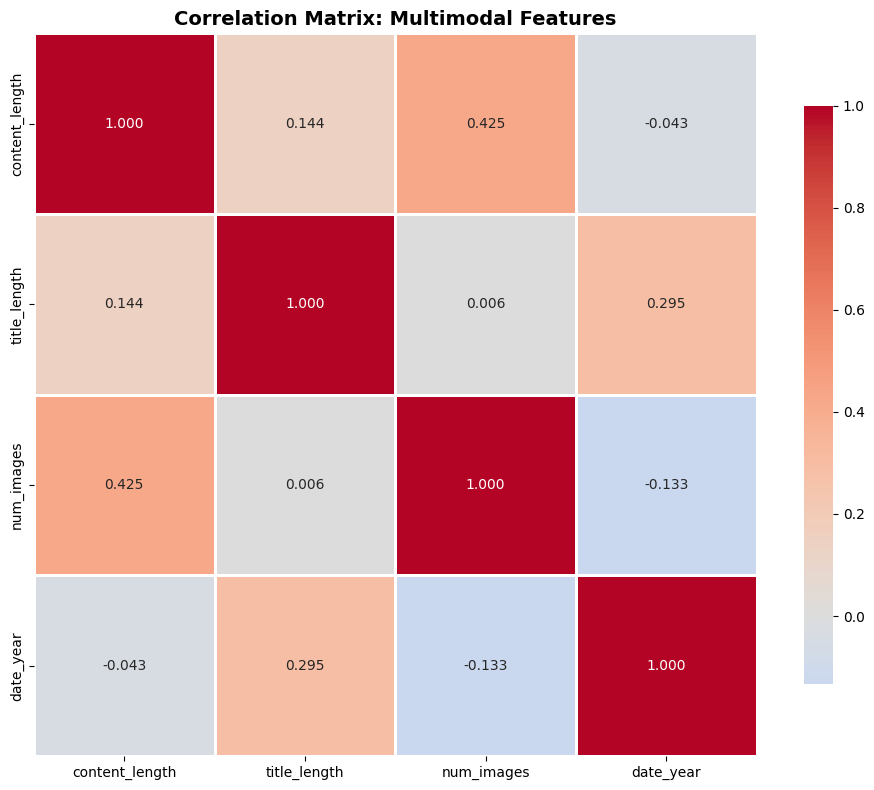


Saved visualization: multimodal_correlation_matrix.png

Key Correlations (|r| > 0.3):
  content_length <-> num_images: r=0.425, p=0.0000 ***


5408

In [65]:
print("QUANTITATIVE RELATIONSHIPS: CORRELATION MATRIX")

print("\nPreparing features for correlation analysis...")

corr_features = ['content_length', 'title_length', 'num_images']
if 'parsed_date' in df_articles.columns:
    df_with_dates = df_articles[df_articles['parsed_date'].notna()].copy()
    if df_with_dates['parsed_date'].dt.tz is not None:
        df_with_dates['date_year'] = df_with_dates['parsed_date'].dt.tz_convert('UTC').dt.year
    else:
        df_with_dates['date_year'] = df_with_dates['parsed_date'].dt.year
    df_corr = df_with_dates
    corr_features.append('date_year')
else:
    df_corr = df_articles

df_corr_subset = df_corr[corr_features].dropna()

print(f"\nComputing correlation matrix on {len(df_corr_subset)} samples...")
correlation_matrix = df_corr_subset.corr()

print(f"\nCorrelation Matrix:")
print(correlation_matrix.round(3))

print(f"\nStatistical Significance Tests (p-values):")
p_value_matrix = pd.DataFrame(index=correlation_matrix.index, columns=correlation_matrix.columns, dtype=float)

for i, col1 in enumerate(correlation_matrix.columns):
    for j, col2 in enumerate(correlation_matrix.columns):
        if i < j:
            _, p_value = pearsonr(df_corr_subset[col1], df_corr_subset[col2])
            p_value_matrix.loc[col1, col2] = p_value
            p_value_matrix.loc[col2, col1] = p_value
        elif i == j:
            p_value_matrix.loc[col1, col2] = 0.0

print(p_value_matrix.round(4))

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Multimodal Features', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('multimodal_correlation_matrix.png', dpi=CONFIG.DPI, bbox_inches='tight')
plt.show()

print(f"\nSaved visualization: multimodal_correlation_matrix.png")

print(f"\nKey Correlations (|r| > 0.3):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.3:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            p_val = p_value_matrix.loc[col1, col2]
            significance = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else "ns"))
            print(f"  {col1} <-> {col2}: r={corr_val:.3f}, p={p_val:.4f} {significance}")


gc.collect()


## 2. Temporal Evolution

TEMPORAL EVOLUTION ANALYSIS

Analyzing trends over time...

Temporal Trends by Year:
 year  avg_images  avg_content_length  avg_title_length  article_count
 2011    1.727873         3296.787318         54.920740            757
 2012    2.868224         5470.079330         58.086822           2269
 2013    3.760905         5974.858374         58.258481           1857
 2014    4.472841         6231.878005         58.942119           1123
 2015    6.542535         6656.744789         53.220845           1775
 2016    5.718416         6303.265125         57.302046           2248
 2017    4.258888         6338.239359         61.983976           1997
 2018    3.906802         6055.524991         68.662533           2661
 2019    1.903871         4706.447805         67.134632          39218
 2020    1.863021         4803.116621         70.661915          20974
 2021    1.930544         4936.551493         72.472068          18760
 2022    1.919543         4840.167164         74.216931        

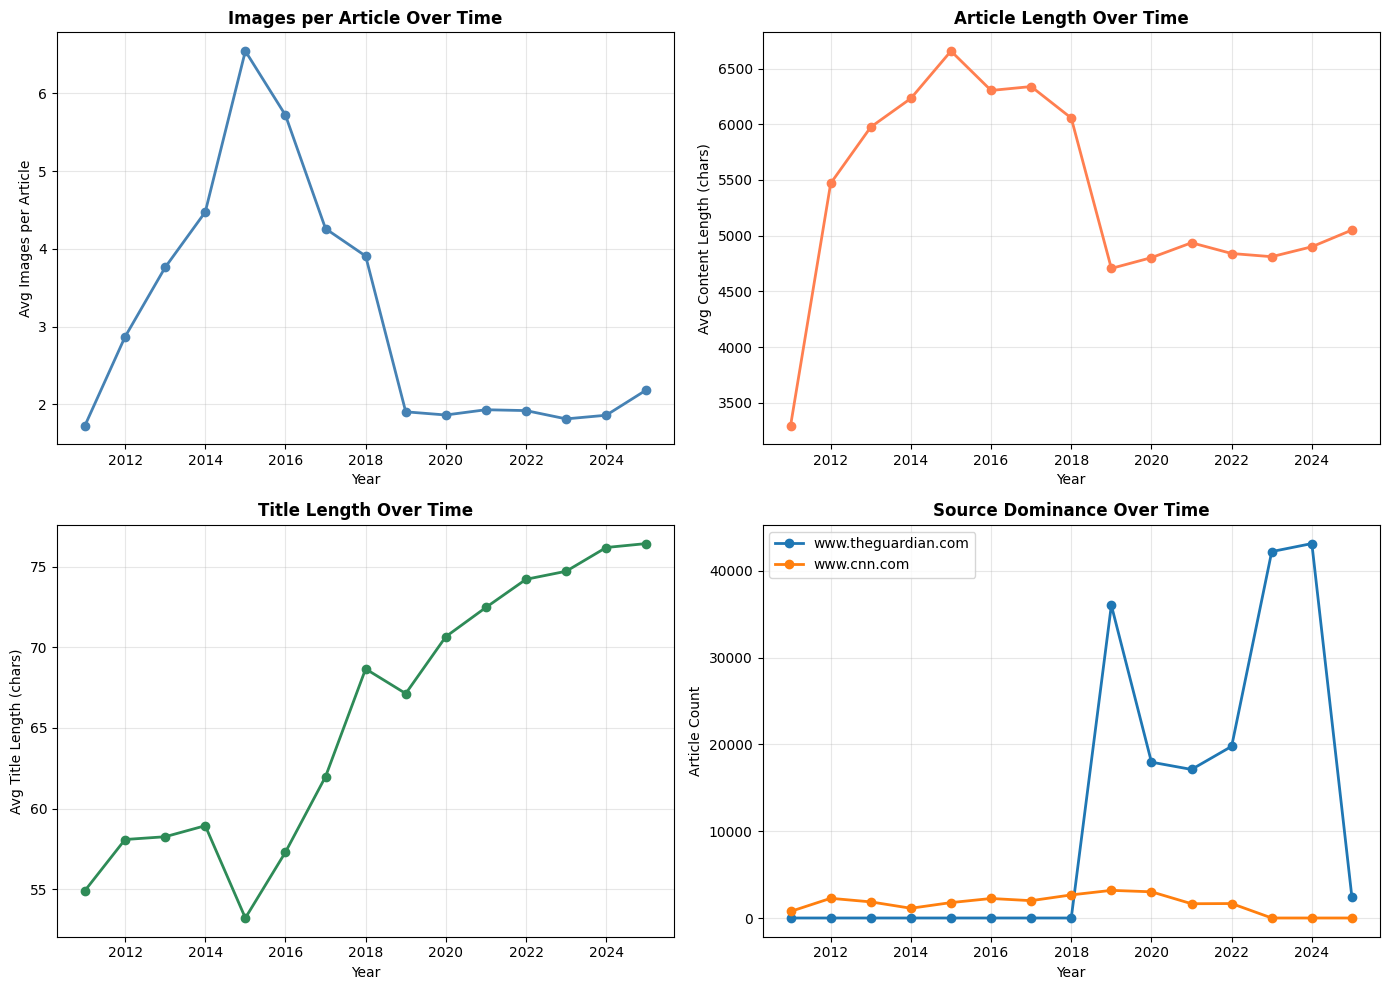


Saved visualization: multimodal_temporal_evolution.png


12126

In [67]:
print("TEMPORAL EVOLUTION ANALYSIS")

if 'date_year' in df_corr.columns:
    print("\nAnalyzing trends over time...")
    
    yearly_stats = df_corr.groupby('date_year').agg({
        'num_images': 'mean',
        'content_length': 'mean',
        'title_length': 'mean',
        'id': 'count'
    }).reset_index()
    
    yearly_stats.columns = ['year', 'avg_images', 'avg_content_length', 
                            'avg_title_length', 'article_count']
    
    print(f"\nTemporal Trends by Year:")
    print(yearly_stats.to_string(index=False))
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    axes[0, 0].plot(yearly_stats['year'], yearly_stats['avg_images'], 
                    marker='o', linewidth=2, color='steelblue')
    axes[0, 0].set_xlabel('Year')
    axes[0, 0].set_ylabel('Avg Images per Article')
    axes[0, 0].set_title('Images per Article Over Time', fontweight='bold')
    axes[0, 0].grid(alpha=0.3)
    
    axes[0, 1].plot(yearly_stats['year'], yearly_stats['avg_content_length'], 
                    marker='o', linewidth=2, color='coral')
    axes[0, 1].set_xlabel('Year')
    axes[0, 1].set_ylabel('Avg Content Length (chars)')
    axes[0, 1].set_title('Article Length Over Time', fontweight='bold')
    axes[0, 1].grid(alpha=0.3)
    
    axes[1, 0].plot(yearly_stats['year'], yearly_stats['avg_title_length'], 
                    marker='o', linewidth=2, color='seagreen')
    axes[1, 0].set_xlabel('Year')
    axes[1, 0].set_ylabel('Avg Title Length (chars)')
    axes[1, 0].set_title('Title Length Over Time', fontweight='bold')
    axes[1, 0].grid(alpha=0.3)
    
    source_by_year = df_corr.groupby(['date_year', 'domain']).size().unstack(fill_value=0)
    top_sources = df_corr['domain'].value_counts().head(3).index
    
    for source in top_sources:
        if source in source_by_year.columns:
            axes[1, 1].plot(source_by_year.index, source_by_year[source], 
                           marker='o', linewidth=2, label=source)
    
    axes[1, 1].set_xlabel('Year')
    axes[1, 1].set_ylabel('Article Count')
    axes[1, 1].set_title('Source Dominance Over Time', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('multimodal_temporal_evolution.png', dpi=CONFIG.DPI, bbox_inches='tight')
    plt.show()
    
    print(f"\nSaved visualization: multimodal_temporal_evolution.png")
    
    del fig, axes
else:
    print("\nTemporal analysis skipped - no date information available")


gc.collect()


## 3. Composite Analysis

COMPOSITE ANALYSIS: ARTICLE SEGMENTS

Analyzing characteristics of different article types...

Segment Sizes:
  High-image (>10): 2691 articles (1.3%)
  No-image (0): 10484 articles (5.2%)
  Long (>10k chars): 9817 articles (4.8%)
  Short (<1k chars): 2181 articles (1.1%)

Segment Characteristics:

High-image (>10):
  Avg content length: 11206 chars
  Avg title length: 65 chars
  Avg images: 18.45

No-image (0):
  Avg content length: 4065 chars
  Avg title length: 69 chars
  Avg images: 0.00

Long (>10k chars):
  Avg content length: 14670 chars
  Avg title length: 74 chars
  Avg images: 6.41

Short (<1k chars):
  Avg content length: 701 chars
  Avg title length: 54 chars
  Avg images: 1.11

High-image Articles Pattern:
  Top categories:
    sports: 965 (35.9%)
    politics: 669 (24.9%)
    entertainment: 354 (13.2%)
  Top sources:
    www.cnn.com: 1800
    www.theguardian.com: 891

No-image Articles Pattern:
  Avg content length: 4065 chars
  Short articles (<1k chars): 519 (5.0%)


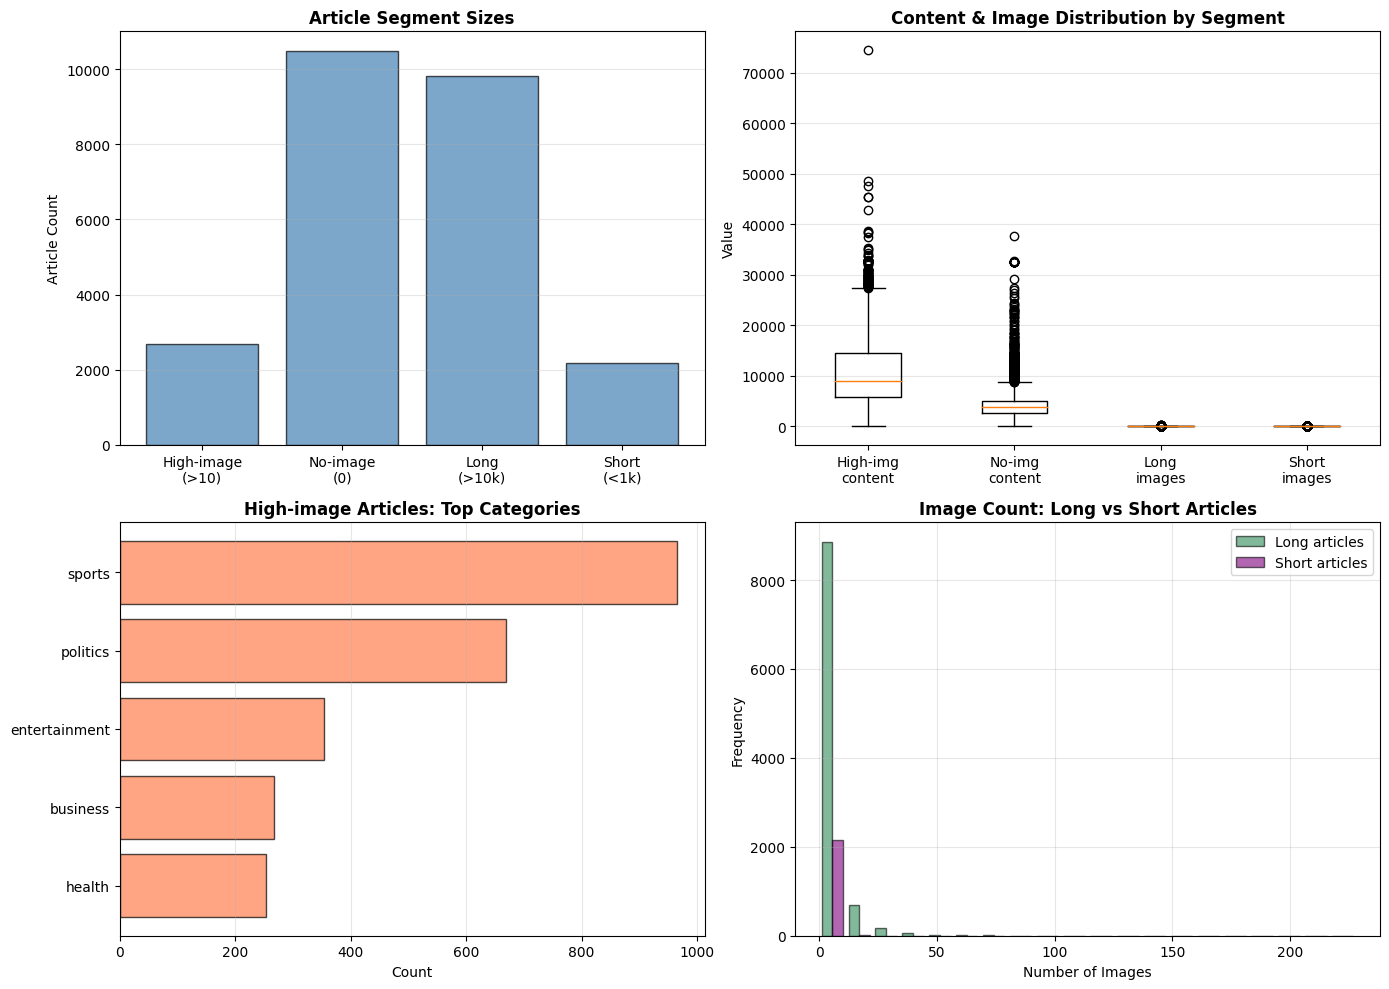


Saved visualization: multimodal_composite_analysis.png


14553

In [68]:
print("COMPOSITE ANALYSIS: ARTICLE SEGMENTS")

print("\nAnalyzing characteristics of different article types...")

high_image_articles = df_corr[df_corr['num_images'] > 10]
no_image_articles = df_corr[df_corr['num_images'] == 0]
long_articles = df_corr[df_corr['content_length'] > 10000]
short_articles = df_corr[df_corr['content_length'] < 1000]

segments = {
    'High-image (>10)': high_image_articles,
    'No-image (0)': no_image_articles,
    'Long (>10k chars)': long_articles,
    'Short (<1k chars)': short_articles
}

print(f"\nSegment Sizes:")
for segment_name, segment_df in segments.items():
    print(f"  {segment_name}: {len(segment_df)} articles ({len(segment_df)/len(df_corr)*100:.1f}%)")

print(f"\nSegment Characteristics:")
for segment_name, segment_df in segments.items():
    if len(segment_df) > 0:
        print(f"\n{segment_name}:")
        print(f"  Avg content length: {segment_df['content_length'].mean():.0f} chars")
        print(f"  Avg title length: {segment_df['title_length'].mean():.0f} chars")
        print(f"  Avg images: {segment_df['num_images'].mean():.2f}")

print(f"\nHigh-image Articles Pattern:")
if len(high_image_articles) > 0 and 'inferred_category' in high_image_articles.columns:
    top_categories = high_image_articles['inferred_category'].value_counts().head(3)
    print(f"  Top categories:")
    for cat, count in top_categories.items():
        print(f"    {cat}: {count} ({count/len(high_image_articles)*100:.1f}%)")
    
    top_domains = high_image_articles['domain'].value_counts().head(3)
    print(f"  Top sources:")
    for domain, count in top_domains.items():
        print(f"    {domain}: {count}")

print(f"\nNo-image Articles Pattern:")
if len(no_image_articles) > 0:
    print(f"  Avg content length: {no_image_articles['content_length'].mean():.0f} chars")
    short_no_img = (no_image_articles['content_length'] < 1000).sum()
    print(f"  Short articles (<1k chars): {short_no_img} ({short_no_img/len(no_image_articles)*100:.1f}%)")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

segment_names = ['High-image\n(>10)', 'No-image\n(0)', 'Long\n(>10k)', 'Short\n(<1k)']
segment_counts = [len(segments[k]) for k in ['High-image (>10)', 'No-image (0)', 
                                               'Long (>10k chars)', 'Short (<1k chars)']]

axes[0, 0].bar(range(len(segment_names)), segment_counts, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xticks(range(len(segment_names)))
axes[0, 0].set_xticklabels(segment_names)
axes[0, 0].set_ylabel('Article Count')
axes[0, 0].set_title('Article Segment Sizes', fontweight='bold')
axes[0, 0].grid(alpha=0.3, axis='y')

boxplot_data = [high_image_articles['content_length'], 
                no_image_articles['content_length'],
                long_articles['num_images'],
                short_articles['num_images']]
boxplot_labels = ['High-img\ncontent', 'No-img\ncontent', 'Long\nimages', 'Short\nimages']

axes[0, 1].boxplot(boxplot_data, labels=boxplot_labels)
axes[0, 1].set_ylabel('Value')
axes[0, 1].set_title('Content & Image Distribution by Segment', fontweight='bold')
axes[0, 1].grid(alpha=0.3, axis='y')

if len(high_image_articles) > 0 and 'inferred_category' in high_image_articles.columns:
    cat_counts = high_image_articles['inferred_category'].value_counts().head(5)
    axes[1, 0].barh(range(len(cat_counts)), cat_counts.values, color='coral', edgecolor='black', alpha=0.7)
    axes[1, 0].set_yticks(range(len(cat_counts)))
    axes[1, 0].set_yticklabels(cat_counts.index)
    axes[1, 0].set_xlabel('Count')
    axes[1, 0].set_title('High-image Articles: Top Categories', fontweight='bold')
    axes[1, 0].invert_yaxis()
    axes[1, 0].grid(alpha=0.3, axis='x')

if len(long_articles) > 0 and len(short_articles) > 0:
    axes[1, 1].hist([long_articles['num_images'], short_articles['num_images']], 
                    bins=20, label=['Long articles', 'Short articles'], 
                    color=['seagreen', 'purple'], edgecolor='black', alpha=0.6)
    axes[1, 1].set_xlabel('Number of Images')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Image Count: Long vs Short Articles', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('multimodal_composite_analysis.png', dpi=CONFIG.DPI, bbox_inches='tight')
plt.show()

print(f"\nSaved visualization: multimodal_composite_analysis.png")

del fig, axes
gc.collect()


## 4. Summary Report

In [71]:
print("MULTIMODAL PATTERN ANALYSIS SUMMARY")

print(f"\nCorrelation Insights:")
strong_corr_count = ((correlation_matrix.abs() > 0.3) & (correlation_matrix.abs() < 1.0)).sum().sum() // 2
print(f"  Strong correlations (|r|>0.3): {strong_corr_count}")

if 'num_images' in correlation_matrix.columns and 'content_length' in correlation_matrix.columns:
    img_content_corr = correlation_matrix.loc['num_images', 'content_length']
    print(f"  Images vs Content length: r={img_content_corr:.3f}")

if 'date_year' in yearly_stats.columns:
    print(f"\nTemporal Trends:")
    img_trend = yearly_stats['avg_images'].iloc[-1] - yearly_stats['avg_images'].iloc[0]
    print(f"  Images per article trend: {'+' if img_trend > 0 else ''}{img_trend:.2f} (from {yearly_stats['year'].iloc[0]} to {yearly_stats['year'].iloc[-1]})")
    
    content_trend = yearly_stats['avg_content_length'].iloc[-1] - yearly_stats['avg_content_length'].iloc[0]
    print(f"  Content length trend: {'+' if content_trend > 0 else ''}{content_trend:.0f} chars")
    
    title_trend = yearly_stats['avg_title_length'].iloc[-1] - yearly_stats['avg_title_length'].iloc[0]
    print(f"  Title length trend: {'+' if title_trend > 0 else ''}{title_trend:.0f} chars")

print(f"\nSegment Insights:")
print(f"  High-image articles: {len(high_image_articles)} ({len(high_image_articles)/len(df_corr)*100:.1f}%)")
print(f"  No-image articles: {len(no_image_articles)} ({len(no_image_articles)/len(df_corr)*100:.1f}%)")
print(f"  Long articles: {len(long_articles)} ({len(long_articles)/len(df_corr)*100:.1f}%)")
print(f"  Short articles: {len(short_articles)} ({len(short_articles)/len(df_corr)*100:.1f}%)")

MULTIMODAL PATTERN ANALYSIS SUMMARY

Correlation Insights:
  Strong correlations (|r|>0.3): 1
  Images vs Content length: r=0.425

Segment Insights:
  High-image articles: 2691 (1.3%)
  No-image articles: 10484 (5.2%)
  Long articles: 9817 (4.8%)
  Short articles: 2181 (1.1%)
